Pix2Pix Gan

Generator:    
The encoder-decoder architecture consists of:
encoder:
C64-C128-C256-C512-C512-C512-C512-C512
decoder:
CD512-CD512-CD512-C512-C256-C128-C64


Discriminator
C64-C128-C256-C512
After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.    

In [30]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

Descriminator Model

In [31]:
def define_discriminator(image_shape):

	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper

	# source image input
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=image_shape)  #Image we want to generate after training.

	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])

	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt.
    #with a small learning rate and 0.5 beta.
    #The loss for the discriminator is weighted by 50% for each model update.

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

Generator Model-Encoder Block

In [32]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

Generator Model- Decoder Block

In [33]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

Generator Model- U-net

In [34]:
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

Combined Generator and discriminator Model , for updating the generator

In [35]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but
                                                #standalone descriminator will be trainable.

	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)

    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'],
               optimizer=opt, loss_weights=[1,100])
	return model

In [36]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [37]:
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [38]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))


Train pix2pix Models

In [39]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)


In [40]:

from os import listdir
from numpy import asarray, load
from numpy import vstack
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

In [41]:
# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		img_path = path + '/' + filename
		pixels = load_img(img_path, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]


In [42]:
#from google.colab import drive
#drive.mount('/content/drive')

In [43]:
# dataset path
path = 'C:/Users/mihir anand/OneDrive - Indian Institute of Technology Guwahati/Desktop/MAPS/train'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


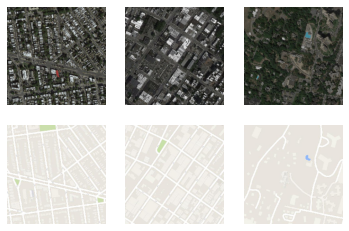

In [44]:
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [45]:
# define input shape based on the loaded dataset
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

C:\Users\mihir anand\anaconda3\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [46]:
#Define data
# load and prepare training images
data = [src_images, tar_images]

In [47]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)


In [48]:
from datetime import datetime
start1 = datetime.now()

train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1)
#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see 10960

stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 [==============================] - 1s 1s/step
>1, d1[0.427] d2[2.157] g[75.525]
1/1 [==============================] - 0s 177ms/step
>2, d1[0.499] d2[1.596] g[62.878]
1/1 [==============================] - 0s 158ms/step
>3, d1[1.353] d2[1.977] g[67.018]
1/1 [==============================] - 0s 166ms/step
>4, d1[0.606] d2[1.244] g[39.848]
1/1 [==============================] - 0s 158ms/step
>5, d1[0.690] d2[0.595] g[42.117]
1/1 [==============================] - 0s 164ms/step
>6, d1[0.551] d2[0.501] g[33.930]
1/1 [==============================] - 0s 171ms/step
>7, d1[0.556] d2[0.498] g[18.449]
1/1 [==============================] - 0s 168ms/step
>8, d1[0.497] d2[0.493] g[22.011]
1/1 [==============================] - 0s 210ms/step
>9, d1[0.474] d2[0.529] g[27.997]
1/1 [==============================] - 0s 165ms/step
>10, d1[0.509] d2[0.453] g[15.630]
1/1 [==============================] - 0s 181ms/step
>11, d1[0.548] d2[0.454] g[11.212]
1/1 [==============================] - 0s 17

>94, d1[0.358] d2[0.391] g[21.099]
1/1 [==============================] - 0s 158ms/step
>95, d1[0.497] d2[0.348] g[18.076]
1/1 [==============================] - 0s 137ms/step
>96, d1[0.396] d2[0.351] g[11.462]
1/1 [==============================] - 0s 136ms/step
>97, d1[0.362] d2[0.485] g[13.286]
1/1 [==============================] - 0s 169ms/step
>98, d1[0.342] d2[0.379] g[12.961]
1/1 [==============================] - 0s 163ms/step
>99, d1[0.562] d2[0.419] g[21.031]
1/1 [==============================] - 0s 150ms/step
>100, d1[0.472] d2[0.627] g[8.550]
1/1 [==============================] - 0s 144ms/step
>101, d1[0.548] d2[0.412] g[23.765]
1/1 [==============================] - 0s 141ms/step
>102, d1[0.413] d2[0.436] g[16.393]
1/1 [==============================] - 0s 158ms/step
>103, d1[0.297] d2[0.417] g[23.927]
1/1 [==============================] - 0s 143ms/step
>104, d1[0.628] d2[0.583] g[13.001]
1/1 [==============================] - 0s 186ms/step
>105, d1[0.366] d2[0.463] g[

1/1 [==============================] - 0s 171ms/step
>187, d1[0.047] d2[0.083] g[16.562]
1/1 [==============================] - 0s 173ms/step
>188, d1[0.033] d2[0.067] g[14.660]
1/1 [==============================] - 0s 181ms/step
>189, d1[0.124] d2[0.058] g[10.257]
1/1 [==============================] - 0s 182ms/step
>190, d1[0.040] d2[0.054] g[10.436]
1/1 [==============================] - 0s 238ms/step
>191, d1[0.034] d2[0.054] g[14.499]
1/1 [==============================] - 0s 161ms/step
>192, d1[0.846] d2[1.713] g[7.055]
1/1 [==============================] - 0s 174ms/step
>193, d1[0.100] d2[0.929] g[8.426]
1/1 [==============================] - 0s 157ms/step
>194, d1[0.131] d2[0.618] g[8.380]
1/1 [==============================] - 0s 150ms/step
>195, d1[0.300] d2[0.349] g[12.974]
1/1 [==============================] - 0s 164ms/step
>196, d1[0.548] d2[0.398] g[16.784]
1/1 [==============================] - 0s 160ms/step
>197, d1[0.645] d2[0.498] g[24.383]
1/1 [===================

1/1 [==============================] - 0s 197ms/step
>279, d1[0.441] d2[0.359] g[10.142]
1/1 [==============================] - 0s 194ms/step
>280, d1[0.370] d2[0.345] g[13.797]
1/1 [==============================] - 0s 197ms/step
>281, d1[0.104] d2[0.283] g[13.950]
1/1 [==============================] - 0s 203ms/step
>282, d1[0.236] d2[0.254] g[11.434]
1/1 [==============================] - 0s 182ms/step
>283, d1[0.177] d2[0.287] g[10.543]
1/1 [==============================] - 0s 169ms/step
>284, d1[0.039] d2[0.164] g[18.503]
1/1 [==============================] - 0s 170ms/step
>285, d1[0.623] d2[0.215] g[16.600]
1/1 [==============================] - 0s 163ms/step
>286, d1[0.485] d2[0.348] g[8.726]
1/1 [==============================] - 0s 165ms/step
>287, d1[0.032] d2[0.255] g[14.140]
1/1 [==============================] - 0s 179ms/step
>288, d1[0.646] d2[0.272] g[8.281]
1/1 [==============================] - 0s 194ms/step
>289, d1[0.068] d2[0.268] g[15.714]
1/1 [==================

1/1 [==============================] - 0s 136ms/step
>371, d1[0.076] d2[0.237] g[16.757]
1/1 [==============================] - 0s 130ms/step
>372, d1[0.470] d2[0.297] g[8.307]
1/1 [==============================] - 0s 128ms/step
>373, d1[0.432] d2[0.333] g[21.081]
1/1 [==============================] - 0s 130ms/step
>374, d1[0.043] d2[0.239] g[22.525]
1/1 [==============================] - 0s 126ms/step
>375, d1[0.519] d2[0.290] g[10.583]
1/1 [==============================] - 0s 128ms/step
>376, d1[0.177] d2[0.293] g[9.806]
1/1 [==============================] - 0s 125ms/step
>377, d1[0.051] d2[0.194] g[18.152]
1/1 [==============================] - 0s 137ms/step
>378, d1[0.283] d2[0.233] g[10.695]
1/1 [==============================] - 0s 167ms/step
>379, d1[0.229] d2[0.225] g[9.745]
1/1 [==============================] - 0s 145ms/step
>380, d1[0.569] d2[0.362] g[5.689]
1/1 [==============================] - 0s 144ms/step
>381, d1[0.146] d2[0.224] g[17.915]
1/1 [====================

1/1 [==============================] - 0s 143ms/step
>463, d1[0.466] d2[0.397] g[16.954]
1/1 [==============================] - 0s 145ms/step
>464, d1[0.442] d2[0.307] g[7.779]
1/1 [==============================] - 0s 159ms/step
>465, d1[0.047] d2[0.215] g[20.330]
1/1 [==============================] - 0s 165ms/step
>466, d1[0.654] d2[0.243] g[9.938]
1/1 [==============================] - 0s 157ms/step
>467, d1[0.414] d2[0.331] g[13.067]
1/1 [==============================] - 0s 154ms/step
>468, d1[0.212] d2[0.288] g[12.438]
1/1 [==============================] - 0s 151ms/step
>469, d1[0.027] d2[0.201] g[21.741]
1/1 [==============================] - 0s 144ms/step
>470, d1[0.489] d2[0.246] g[8.045]
1/1 [==============================] - 0s 150ms/step
>471, d1[0.050] d2[0.235] g[13.089]
1/1 [==============================] - 0s 157ms/step
>472, d1[0.017] d2[0.211] g[21.963]
1/1 [==============================] - 0s 151ms/step
>473, d1[0.023] d2[0.174] g[12.869]
1/1 [===================

1/1 [==============================] - 0s 250ms/step
>555, d1[0.035] d2[0.246] g[21.744]
1/1 [==============================] - 0s 142ms/step
>556, d1[0.209] d2[0.251] g[9.191]
1/1 [==============================] - 0s 162ms/step
>557, d1[0.054] d2[0.237] g[13.709]
1/1 [==============================] - 0s 139ms/step
>558, d1[0.407] d2[0.254] g[11.667]
1/1 [==============================] - 0s 152ms/step
>559, d1[0.452] d2[0.342] g[7.319]
1/1 [==============================] - 0s 142ms/step
>560, d1[0.080] d2[0.301] g[10.357]
1/1 [==============================] - 0s 146ms/step
>561, d1[0.032] d2[0.185] g[18.107]
1/1 [==============================] - 0s 142ms/step
>562, d1[0.239] d2[0.207] g[10.509]
1/1 [==============================] - 0s 153ms/step
>563, d1[0.015] d2[0.200] g[11.971]
1/1 [==============================] - 0s 142ms/step
>564, d1[0.069] d2[0.271] g[18.385]
1/1 [==============================] - 0s 152ms/step
>565, d1[0.152] d2[0.153] g[12.099]
1/1 [==================

1/1 [==============================] - 0s 156ms/step
>647, d1[0.194] d2[0.226] g[14.856]
1/1 [==============================] - 0s 172ms/step
>648, d1[0.488] d2[0.352] g[19.884]
1/1 [==============================] - 0s 180ms/step
>649, d1[0.208] d2[0.261] g[19.835]
1/1 [==============================] - 0s 158ms/step
>650, d1[0.187] d2[0.213] g[14.908]
1/1 [==============================] - 0s 161ms/step
>651, d1[0.545] d2[0.350] g[10.123]
1/1 [==============================] - 0s 174ms/step
>652, d1[0.405] d2[0.500] g[9.797]
1/1 [==============================] - 0s 159ms/step
>653, d1[0.398] d2[0.333] g[8.841]
1/1 [==============================] - 0s 170ms/step
>654, d1[0.225] d2[0.311] g[9.896]
1/1 [==============================] - 0s 156ms/step
>655, d1[0.414] d2[0.279] g[8.622]
1/1 [==============================] - 0s 153ms/step
>656, d1[0.396] d2[0.358] g[13.928]
1/1 [==============================] - 0s 171ms/step
>657, d1[0.200] d2[0.335] g[10.846]
1/1 [====================

1/1 [==============================] - 0s 187ms/step
>739, d1[0.620] d2[0.892] g[10.125]
1/1 [==============================] - 0s 197ms/step
>740, d1[0.225] d2[0.249] g[9.696]
1/1 [==============================] - 0s 191ms/step
>741, d1[0.311] d2[0.230] g[9.433]
1/1 [==============================] - 0s 207ms/step
>742, d1[0.051] d2[0.522] g[25.647]
1/1 [==============================] - 0s 185ms/step
>743, d1[0.273] d2[0.148] g[13.321]
1/1 [==============================] - 0s 191ms/step
>744, d1[0.573] d2[0.407] g[17.103]
1/1 [==============================] - 0s 177ms/step
>745, d1[0.203] d2[0.206] g[20.499]
1/1 [==============================] - 0s 189ms/step
>746, d1[0.376] d2[0.225] g[10.400]
1/1 [==============================] - 0s 172ms/step
>747, d1[0.018] d2[0.296] g[21.620]
1/1 [==============================] - 0s 171ms/step
>748, d1[0.269] d2[0.191] g[10.284]
1/1 [==============================] - 0s 188ms/step
>749, d1[0.287] d2[0.367] g[16.802]
1/1 [==================

1/1 [==============================] - 0s 150ms/step
>831, d1[0.036] d2[0.165] g[18.431]
1/1 [==============================] - 0s 158ms/step
>832, d1[0.973] d2[0.157] g[9.464]
1/1 [==============================] - 0s 189ms/step
>833, d1[0.019] d2[0.229] g[13.414]
1/1 [==============================] - 0s 159ms/step
>834, d1[0.492] d2[0.260] g[8.589]
1/1 [==============================] - 0s 171ms/step
>835, d1[0.028] d2[0.197] g[15.030]
1/1 [==============================] - 0s 172ms/step
>836, d1[0.379] d2[0.237] g[8.540]
1/1 [==============================] - 0s 175ms/step
>837, d1[0.359] d2[0.447] g[14.125]
1/1 [==============================] - 0s 161ms/step
>838, d1[0.236] d2[0.393] g[11.966]
1/1 [==============================] - 0s 150ms/step
>839, d1[0.034] d2[0.173] g[10.546]
1/1 [==============================] - 0s 144ms/step
>840, d1[0.058] d2[0.115] g[14.566]
1/1 [==============================] - 0s 142ms/step
>841, d1[0.031] d2[0.110] g[19.912]
1/1 [===================

1/1 [==============================] - 0s 144ms/step
>923, d1[0.018] d2[0.124] g[12.507]
1/1 [==============================] - 0s 137ms/step
>924, d1[0.382] d2[0.224] g[8.806]
1/1 [==============================] - 0s 145ms/step
>925, d1[0.069] d2[0.173] g[10.395]
1/1 [==============================] - 0s 131ms/step
>926, d1[0.093] d2[0.198] g[8.648]
1/1 [==============================] - 0s 136ms/step
>927, d1[0.108] d2[0.225] g[10.229]
1/1 [==============================] - 0s 136ms/step
>928, d1[0.078] d2[0.112] g[11.308]
1/1 [==============================] - 0s 145ms/step
>929, d1[0.640] d2[0.567] g[18.959]
1/1 [==============================] - 0s 142ms/step
>930, d1[0.070] d2[0.257] g[18.143]
1/1 [==============================] - 0s 151ms/step
>931, d1[0.475] d2[0.601] g[12.281]
1/1 [==============================] - 0s 150ms/step
>932, d1[0.950] d2[0.310] g[12.162]
1/1 [==============================] - 0s 143ms/step
>933, d1[0.166] d2[0.262] g[17.679]
1/1 [==================

1/1 [==============================] - 0s 151ms/step
>1015, d1[0.383] d2[0.343] g[8.879]
1/1 [==============================] - 0s 148ms/step
>1016, d1[0.235] d2[0.361] g[8.025]
1/1 [==============================] - 0s 144ms/step
>1017, d1[0.752] d2[0.504] g[10.341]
1/1 [==============================] - 0s 157ms/step
>1018, d1[0.044] d2[0.138] g[22.496]
1/1 [==============================] - 0s 149ms/step
>1019, d1[0.775] d2[0.259] g[10.158]
1/1 [==============================] - 0s 140ms/step
>1020, d1[0.020] d2[0.252] g[13.784]
1/1 [==============================] - 0s 150ms/step
>1021, d1[0.268] d2[0.424] g[11.772]
1/1 [==============================] - 0s 144ms/step
>1022, d1[0.579] d2[0.303] g[8.154]
1/1 [==============================] - 0s 136ms/step
>1023, d1[0.309] d2[0.342] g[8.650]
1/1 [==============================] - 0s 138ms/step
>1024, d1[0.318] d2[0.408] g[8.806]
1/1 [==============================] - 0s 139ms/step
>1025, d1[0.035] d2[0.136] g[14.835]
1/1 [==========

1/1 [==============================] - 0s 146ms/step
>1106, d1[0.658] d2[0.312] g[11.646]
1/1 [==============================] - 0s 144ms/step
>1107, d1[0.393] d2[0.362] g[8.989]
1/1 [==============================] - 0s 136ms/step
>1108, d1[0.384] d2[0.393] g[8.471]
1/1 [==============================] - 0s 144ms/step
>1109, d1[0.322] d2[0.418] g[8.252]
1/1 [==============================] - 0s 138ms/step
>1110, d1[0.083] d2[0.295] g[16.127]
1/1 [==============================] - 0s 133ms/step
>1111, d1[0.550] d2[0.289] g[8.612]
1/1 [==============================] - 0s 141ms/step
>1112, d1[0.023] d2[0.234] g[11.002]
1/1 [==============================] - 0s 134ms/step
>1113, d1[0.532] d2[0.555] g[9.453]
1/1 [==============================] - 0s 148ms/step
>1114, d1[0.424] d2[0.351] g[8.338]
1/1 [==============================] - 0s 142ms/step
>1115, d1[0.116] d2[0.265] g[13.686]
1/1 [==============================] - 0s 148ms/step
>1116, d1[0.810] d2[0.283] g[9.946]
1/1 [============

1/1 [==============================] - 0s 169ms/step
>1197, d1[0.335] d2[0.399] g[7.902]
1/1 [==============================] - 0s 182ms/step
>1198, d1[0.028] d2[0.213] g[13.250]
1/1 [==============================] - 0s 191ms/step
>1199, d1[0.275] d2[0.245] g[15.367]
1/1 [==============================] - 0s 157ms/step
>1200, d1[0.477] d2[0.360] g[7.819]
1/1 [==============================] - 0s 152ms/step
>1201, d1[0.067] d2[0.446] g[10.569]
1/1 [==============================] - 0s 146ms/step
>1202, d1[0.953] d2[0.180] g[13.900]
1/1 [==============================] - 0s 154ms/step
>1203, d1[0.236] d2[0.271] g[11.830]
1/1 [==============================] - 0s 189ms/step
>1204, d1[0.028] d2[0.181] g[17.095]
1/1 [==============================] - 0s 141ms/step
>1205, d1[0.271] d2[0.247] g[8.054]
1/1 [==============================] - 0s 143ms/step
>1206, d1[0.166] d2[0.243] g[7.927]
1/1 [==============================] - 0s 139ms/step
>1207, d1[0.736] d2[0.345] g[6.800]
1/1 [==========

1/1 [==============================] - 0s 158ms/step
>1288, d1[0.825] d2[0.225] g[7.960]
1/1 [==============================] - 0s 174ms/step
>1289, d1[0.602] d2[0.543] g[8.055]
1/1 [==============================] - 0s 149ms/step
>1290, d1[0.096] d2[0.270] g[13.424]
1/1 [==============================] - 0s 154ms/step
>1291, d1[0.028] d2[0.151] g[16.354]
1/1 [==============================] - 0s 152ms/step
>1292, d1[0.781] d2[0.320] g[9.964]
1/1 [==============================] - 0s 155ms/step
>1293, d1[0.453] d2[0.351] g[6.997]
1/1 [==============================] - 0s 169ms/step
>1294, d1[0.024] d2[0.222] g[18.047]
1/1 [==============================] - 0s 149ms/step
>1295, d1[0.198] d2[0.201] g[7.955]
1/1 [==============================] - 0s 165ms/step
>1296, d1[0.132] d2[0.186] g[17.276]
1/1 [==============================] - 0s 190ms/step
>1297, d1[0.641] d2[0.341] g[6.903]
1/1 [==============================] - 0s 184ms/step
>1298, d1[0.012] d2[0.210] g[28.157]
1/1 [===========

1/1 [==============================] - 0s 154ms/step
>1379, d1[0.459] d2[0.432] g[10.098]
1/1 [==============================] - 0s 149ms/step
>1380, d1[0.544] d2[0.482] g[12.382]
1/1 [==============================] - 0s 159ms/step
>1381, d1[0.325] d2[0.492] g[9.127]
1/1 [==============================] - 0s 148ms/step
>1382, d1[0.458] d2[0.443] g[8.709]
1/1 [==============================] - 0s 148ms/step
>1383, d1[0.221] d2[0.254] g[11.088]
1/1 [==============================] - 0s 148ms/step
>1384, d1[0.593] d2[0.357] g[8.414]
1/1 [==============================] - 0s 153ms/step
>1385, d1[0.166] d2[0.487] g[15.664]
1/1 [==============================] - 0s 143ms/step
>1386, d1[0.213] d2[0.180] g[21.595]
1/1 [==============================] - 0s 152ms/step
>1387, d1[0.630] d2[0.331] g[11.182]
1/1 [==============================] - 0s 146ms/step
>1388, d1[0.371] d2[0.467] g[9.696]
1/1 [==============================] - 0s 157ms/step
>1389, d1[0.341] d2[0.527] g[10.273]
1/1 [=========

1/1 [==============================] - 0s 183ms/step
>1470, d1[0.630] d2[0.798] g[10.770]
1/1 [==============================] - 0s 168ms/step
>1471, d1[1.003] d2[0.179] g[7.260]
1/1 [==============================] - 0s 173ms/step
>1472, d1[0.539] d2[0.320] g[12.631]
1/1 [==============================] - 0s 173ms/step
>1473, d1[0.279] d2[0.377] g[8.444]
1/1 [==============================] - 0s 175ms/step
>1474, d1[0.215] d2[0.320] g[8.396]
1/1 [==============================] - 0s 180ms/step
>1475, d1[0.393] d2[0.321] g[9.898]
1/1 [==============================] - 0s 184ms/step
>1476, d1[0.198] d2[0.423] g[7.754]
1/1 [==============================] - 0s 190ms/step
>1477, d1[0.041] d2[0.177] g[13.364]
1/1 [==============================] - 0s 190ms/step
>1478, d1[0.275] d2[0.191] g[13.794]
1/1 [==============================] - 0s 207ms/step
>1479, d1[0.252] d2[0.381] g[8.526]
1/1 [==============================] - 0s 210ms/step
>1480, d1[0.628] d2[0.443] g[9.518]
1/1 [============

>1561, d1[0.026] d2[0.109] g[14.855]
1/1 [==============================] - 0s 172ms/step
>1562, d1[0.044] d2[0.085] g[21.020]
1/1 [==============================] - 0s 204ms/step
>1563, d1[0.041] d2[0.105] g[19.637]
1/1 [==============================] - 0s 175ms/step
>1564, d1[0.213] d2[0.508] g[11.155]
1/1 [==============================] - 0s 188ms/step
>1565, d1[0.086] d2[0.054] g[19.621]
1/1 [==============================] - 0s 185ms/step
>1566, d1[1.313] d2[0.109] g[7.429]
1/1 [==============================] - 0s 200ms/step
>1567, d1[0.024] d2[0.157] g[13.094]
1/1 [==============================] - 0s 168ms/step
>1568, d1[0.737] d2[0.266] g[8.918]
1/1 [==============================] - 0s 231ms/step
>1569, d1[0.470] d2[0.460] g[8.275]
1/1 [==============================] - 0s 196ms/step
>1570, d1[0.012] d2[0.229] g[18.580]
1/1 [==============================] - 0s 203ms/step
>1571, d1[0.392] d2[0.237] g[12.391]
1/1 [==============================] - 0s 162ms/step
>1572, d1[0.2

1/1 [==============================] - 0s 194ms/step
>1653, d1[0.091] d2[0.187] g[10.193]
1/1 [==============================] - 0s 228ms/step
>1654, d1[0.092] d2[0.139] g[9.830]
1/1 [==============================] - 0s 184ms/step
>1655, d1[0.039] d2[0.144] g[12.730]
1/1 [==============================] - 0s 174ms/step
>1656, d1[0.512] d2[0.202] g[8.941]
1/1 [==============================] - 0s 173ms/step
>1657, d1[0.228] d2[0.322] g[8.171]
1/1 [==============================] - 0s 215ms/step
>1658, d1[0.514] d2[0.466] g[7.221]
1/1 [==============================] - 0s 250ms/step
>1659, d1[0.253] d2[0.393] g[7.746]
1/1 [==============================] - 0s 184ms/step
>1660, d1[0.009] d2[0.210] g[29.829]
1/1 [==============================] - 0s 177ms/step
>1661, d1[0.519] d2[0.245] g[9.387]
1/1 [==============================] - 0s 184ms/step
>1662, d1[0.015] d2[0.435] g[8.334]
1/1 [==============================] - 0s 172ms/step
>1663, d1[0.051] d2[0.115] g[18.280]
1/1 [============

1/1 [==============================] - 0s 184ms/step
>1744, d1[0.027] d2[0.172] g[9.593]
1/1 [==============================] - 0s 189ms/step
>1745, d1[0.028] d2[0.122] g[14.322]
1/1 [==============================] - 0s 180ms/step
>1746, d1[0.097] d2[0.141] g[9.105]
1/1 [==============================] - 0s 181ms/step
>1747, d1[0.050] d2[0.205] g[19.133]
1/1 [==============================] - 0s 200ms/step
>1748, d1[0.047] d2[0.090] g[16.616]
1/1 [==============================] - 0s 193ms/step
>1749, d1[0.058] d2[0.084] g[17.285]
1/1 [==============================] - 0s 179ms/step
>1750, d1[0.731] d2[1.304] g[11.601]
1/1 [==============================] - 0s 231ms/step
>1751, d1[0.751] d2[0.253] g[10.559]
1/1 [==============================] - 0s 204ms/step
>1752, d1[0.747] d2[0.345] g[10.457]
1/1 [==============================] - 0s 185ms/step
>1753, d1[0.040] d2[0.276] g[19.165]
1/1 [==============================] - 0s 247ms/step
>1754, d1[0.268] d2[0.337] g[9.323]
1/1 [========

>1835, d1[0.555] d2[0.353] g[9.799]
1/1 [==============================] - 0s 184ms/step
>1836, d1[0.311] d2[0.412] g[7.630]
1/1 [==============================] - 0s 219ms/step
>1837, d1[0.038] d2[0.265] g[12.053]
1/1 [==============================] - 0s 203ms/step
>1838, d1[0.609] d2[0.284] g[10.482]
1/1 [==============================] - 0s 171ms/step
>1839, d1[0.357] d2[0.375] g[8.420]
1/1 [==============================] - 0s 184ms/step
>1840, d1[0.329] d2[0.340] g[8.633]
1/1 [==============================] - 0s 168ms/step
>1841, d1[0.143] d2[0.396] g[8.165]
1/1 [==============================] - 0s 170ms/step
>1842, d1[0.046] d2[0.179] g[11.483]
1/1 [==============================] - 0s 168ms/step
>1843, d1[0.624] d2[0.251] g[7.809]
1/1 [==============================] - 0s 184ms/step
>1844, d1[0.064] d2[0.255] g[9.407]
1/1 [==============================] - 0s 189ms/step
>1845, d1[0.020] d2[0.163] g[29.048]
1/1 [==============================] - 0s 180ms/step
>1846, d1[0.035] 

1/1 [==============================] - 0s 200ms/step
>1927, d1[0.049] d2[0.174] g[7.509]
1/1 [==============================] - 0s 195ms/step
>1928, d1[0.034] d2[0.097] g[13.558]
1/1 [==============================] - 0s 240ms/step
>1929, d1[1.073] d2[0.161] g[9.540]
1/1 [==============================] - 0s 258ms/step
>1930, d1[0.016] d2[0.218] g[10.920]
1/1 [==============================] - 0s 202ms/step
>1931, d1[0.126] d2[0.207] g[12.680]
1/1 [==============================] - 0s 182ms/step
>1932, d1[0.504] d2[1.459] g[13.243]
1/1 [==============================] - 0s 180ms/step
>1933, d1[0.139] d2[0.147] g[10.968]
1/1 [==============================] - 0s 194ms/step
>1934, d1[0.113] d2[0.122] g[22.140]
1/1 [==============================] - 0s 221ms/step
>1935, d1[0.101] d2[0.115] g[17.941]
1/1 [==============================] - 0s 245ms/step
>1936, d1[0.355] d2[0.466] g[10.653]
1/1 [==============================] - 0s 240ms/step
>1937, d1[0.058] d2[0.094] g[9.752]
1/1 [========

1/1 [==============================] - 0s 190ms/step
>2018, d1[0.061] d2[0.119] g[10.022]
1/1 [==============================] - 0s 185ms/step
>2019, d1[0.063] d2[0.116] g[12.797]
1/1 [==============================] - 0s 192ms/step
>2020, d1[0.077] d2[0.132] g[10.160]
1/1 [==============================] - 0s 195ms/step
>2021, d1[0.057] d2[0.090] g[24.448]
1/1 [==============================] - 0s 184ms/step
>2022, d1[0.084] d2[0.177] g[10.216]
1/1 [==============================] - 0s 208ms/step
>2023, d1[0.879] d2[0.177] g[9.075]
1/1 [==============================] - 0s 212ms/step
>2024, d1[0.106] d2[0.247] g[7.686]
1/1 [==============================] - 0s 222ms/step
>2025, d1[0.037] d2[0.181] g[7.496]
1/1 [==============================] - 0s 195ms/step
>2026, d1[0.037] d2[0.130] g[13.242]
1/1 [==============================] - 0s 196ms/step
>2027, d1[0.335] d2[0.507] g[10.020]
1/1 [==============================] - 0s 190ms/step
>2028, d1[0.068] d2[0.094] g[9.344]
1/1 [=========

>2109, d1[0.239] d2[0.925] g[18.546]
1/1 [==============================] - 0s 193ms/step
>2110, d1[0.095] d2[0.123] g[9.563]
1/1 [==============================] - 0s 192ms/step
>2111, d1[0.851] d2[0.200] g[6.738]
1/1 [==============================] - 0s 205ms/step
>2112, d1[0.125] d2[0.334] g[9.306]
1/1 [==============================] - 0s 197ms/step
>2113, d1[0.084] d2[0.171] g[9.528]
1/1 [==============================] - 0s 203ms/step
>2114, d1[0.224] d2[0.357] g[8.010]
1/1 [==============================] - 0s 204ms/step
>2115, d1[0.821] d2[0.183] g[6.675]
1/1 [==============================] - 0s 202ms/step
>2116, d1[0.397] d2[0.330] g[7.010]
1/1 [==============================] - 0s 230ms/step
>2117, d1[0.447] d2[0.404] g[5.506]
1/1 [==============================] - 0s 222ms/step
>2118, d1[0.030] d2[0.300] g[13.686]
1/1 [==============================] - 0s 212ms/step
>2119, d1[0.086] d2[0.204] g[7.693]
1/1 [==============================] - 0s 205ms/step
>2120, d1[0.098] d2

1/1 [==============================] - 0s 204ms/step
>2201, d1[0.059] d2[0.443] g[7.800]
1/1 [==============================] - 0s 208ms/step
>2202, d1[0.244] d2[0.112] g[15.590]
1/1 [==============================] - 0s 202ms/step
>2203, d1[0.767] d2[0.205] g[12.518]
1/1 [==============================] - 0s 207ms/step
>2204, d1[0.127] d2[0.297] g[13.083]
1/1 [==============================] - 0s 187ms/step
>2205, d1[0.077] d2[0.218] g[13.390]
1/1 [==============================] - 0s 202ms/step
>2206, d1[0.707] d2[0.233] g[5.772]
1/1 [==============================] - 0s 224ms/step
>2207, d1[0.417] d2[0.408] g[6.380]
1/1 [==============================] - 0s 200ms/step
>2208, d1[0.027] d2[0.293] g[14.113]
1/1 [==============================] - 0s 216ms/step
>2209, d1[0.551] d2[0.288] g[7.235]
1/1 [==============================] - 0s 215ms/step
>2210, d1[0.035] d2[0.230] g[27.025]
1/1 [==============================] - 0s 215ms/step
>2211, d1[0.250] d2[0.274] g[10.874]
1/1 [=========

1/1 [==============================] - 0s 218ms/step
>2292, d1[0.113] d2[0.245] g[10.461]
1/1 [==============================] - 0s 213ms/step
>2293, d1[0.325] d2[0.318] g[10.469]
1/1 [==============================] - 0s 216ms/step
>2294, d1[0.154] d2[0.381] g[7.409]
1/1 [==============================] - 0s 213ms/step
>2295, d1[0.739] d2[0.213] g[7.182]
1/1 [==============================] - 0s 225ms/step
>2296, d1[0.483] d2[0.296] g[9.407]
1/1 [==============================] - 0s 222ms/step
>2297, d1[0.434] d2[0.389] g[22.811]
1/1 [==============================] - 0s 198ms/step
>2298, d1[0.138] d2[0.353] g[10.876]
1/1 [==============================] - 0s 217ms/step
>2299, d1[0.064] d2[0.221] g[9.899]
1/1 [==============================] - 0s 199ms/step
>2300, d1[0.079] d2[0.185] g[8.443]
1/1 [==============================] - 0s 210ms/step
>2301, d1[0.546] d2[0.273] g[7.229]
1/1 [==============================] - 0s 214ms/step
>2302, d1[0.061] d2[0.213] g[14.159]
1/1 [===========

>2383, d1[0.321] d2[0.348] g[13.863]
1/1 [==============================] - 0s 216ms/step
>2384, d1[0.481] d2[0.382] g[5.402]
1/1 [==============================] - 0s 233ms/step
>2385, d1[0.239] d2[0.544] g[6.955]
1/1 [==============================] - 0s 233ms/step
>2386, d1[0.405] d2[0.324] g[11.107]
1/1 [==============================] - 0s 218ms/step
>2387, d1[0.246] d2[0.260] g[15.569]
1/1 [==============================] - 0s 218ms/step
>2388, d1[0.441] d2[0.321] g[8.119]
1/1 [==============================] - 0s 228ms/step
>2389, d1[0.386] d2[0.380] g[7.671]
1/1 [==============================] - 0s 228ms/step
>2390, d1[0.342] d2[0.380] g[7.041]
1/1 [==============================] - 0s 209ms/step
>2391, d1[0.218] d2[0.520] g[10.147]
1/1 [==============================] - 0s 213ms/step
>2392, d1[0.420] d2[0.304] g[7.357]
1/1 [==============================] - 0s 209ms/step
>2393, d1[0.260] d2[0.256] g[10.477]
1/1 [==============================] - 0s 238ms/step
>2394, d1[0.193]

1/1 [==============================] - 0s 232ms/step
>2475, d1[0.329] d2[0.256] g[7.841]
1/1 [==============================] - 0s 231ms/step
>2476, d1[0.079] d2[0.150] g[13.565]
1/1 [==============================] - 0s 230ms/step
>2477, d1[0.222] d2[0.182] g[7.512]
1/1 [==============================] - 0s 224ms/step
>2478, d1[0.081] d2[0.282] g[10.159]
1/1 [==============================] - 0s 226ms/step
>2479, d1[0.301] d2[0.182] g[8.782]
1/1 [==============================] - 0s 221ms/step
>2480, d1[0.072] d2[0.173] g[10.924]
1/1 [==============================] - 0s 218ms/step
>2481, d1[0.077] d2[0.119] g[11.978]
1/1 [==============================] - 0s 240ms/step
>2482, d1[0.197] d2[0.237] g[9.011]
1/1 [==============================] - 0s 234ms/step
>2483, d1[0.080] d2[0.119] g[21.150]
1/1 [==============================] - 0s 222ms/step
>2484, d1[0.303] d2[0.979] g[10.579]
1/1 [==============================] - 0s 222ms/step
>2485, d1[0.149] d2[0.254] g[9.073]
1/1 [==========

>2566, d1[0.366] d2[0.351] g[7.868]
1/1 [==============================] - 0s 231ms/step
>2567, d1[0.060] d2[0.241] g[22.772]
1/1 [==============================] - 0s 226ms/step
>2568, d1[0.162] d2[0.248] g[8.849]
1/1 [==============================] - 0s 231ms/step
>2569, d1[0.084] d2[0.181] g[7.654]
1/1 [==============================] - 0s 238ms/step
>2570, d1[0.090] d2[0.157] g[13.083]
1/1 [==============================] - 0s 251ms/step
>2571, d1[0.210] d2[0.245] g[8.790]
1/1 [==============================] - 0s 250ms/step
>2572, d1[0.107] d2[0.156] g[11.536]
1/1 [==============================] - 0s 236ms/step
>2573, d1[0.093] d2[0.149] g[19.506]
1/1 [==============================] - 0s 227ms/step
>2574, d1[0.130] d2[0.231] g[9.943]
1/1 [==============================] - 0s 229ms/step
>2575, d1[0.096] d2[0.194] g[12.211]
1/1 [==============================] - 0s 233ms/step
>2576, d1[0.130] d2[0.120] g[11.814]
1/1 [==============================] - 0s 231ms/step
>2577, d1[0.137

1/1 [==============================] - 0s 239ms/step
>2658, d1[0.238] d2[0.342] g[8.300]
1/1 [==============================] - 0s 231ms/step
>2659, d1[0.083] d2[0.297] g[8.736]
1/1 [==============================] - 0s 234ms/step
>2660, d1[0.138] d2[0.254] g[8.243]
1/1 [==============================] - 0s 227ms/step
>2661, d1[0.074] d2[0.217] g[13.732]
1/1 [==============================] - 0s 233ms/step
>2662, d1[0.081] d2[0.187] g[19.372]
1/1 [==============================] - 0s 229ms/step
>2663, d1[0.095] d2[0.201] g[10.608]
1/1 [==============================] - 0s 232ms/step
>2664, d1[0.133] d2[0.155] g[10.775]
1/1 [==============================] - 0s 266ms/step
>2665, d1[0.520] d2[0.817] g[11.531]
1/1 [==============================] - 0s 275ms/step
>2666, d1[0.107] d2[0.193] g[19.787]
1/1 [==============================] - 0s 262ms/step
>2667, d1[0.278] d2[0.308] g[10.787]
1/1 [==============================] - 0s 243ms/step
>2668, d1[0.721] d2[0.289] g[8.426]
1/1 [=========

>2749, d1[0.626] d2[0.230] g[9.329]
1/1 [==============================] - 0s 251ms/step
>2750, d1[0.063] d2[0.237] g[14.473]
1/1 [==============================] - 0s 236ms/step
>2751, d1[0.112] d2[0.206] g[8.961]
1/1 [==============================] - 0s 239ms/step
>2752, d1[0.098] d2[0.184] g[9.478]
1/1 [==============================] - 0s 234ms/step
>2753, d1[0.141] d2[0.293] g[14.067]
1/1 [==============================] - 0s 238ms/step
>2754, d1[0.093] d2[0.156] g[16.603]
1/1 [==============================] - 0s 232ms/step
>2755, d1[0.153] d2[0.155] g[12.073]
1/1 [==============================] - 0s 229ms/step
>2756, d1[0.112] d2[0.168] g[9.581]
1/1 [==============================] - 0s 242ms/step
>2757, d1[0.099] d2[0.159] g[8.136]
1/1 [==============================] - 0s 251ms/step
>2758, d1[0.740] d2[0.195] g[6.622]
1/1 [==============================] - 0s 234ms/step
>2759, d1[0.107] d2[0.233] g[7.683]
1/1 [==============================] - 0s 235ms/step
>2760, d1[0.066] 

1/1 [==============================] - 0s 242ms/step
>2841, d1[0.358] d2[0.342] g[7.587]
1/1 [==============================] - 0s 255ms/step
>2842, d1[0.166] d2[0.346] g[6.741]
1/1 [==============================] - 0s 253ms/step
>2843, d1[0.445] d2[0.327] g[4.554]
1/1 [==============================] - 0s 254ms/step
>2844, d1[0.047] d2[0.312] g[10.153]
1/1 [==============================] - 0s 245ms/step
>2845, d1[0.434] d2[0.302] g[8.112]
1/1 [==============================] - 0s 245ms/step
>2846, d1[0.117] d2[0.402] g[7.000]
1/1 [==============================] - 0s 249ms/step
>2847, d1[0.071] d2[0.187] g[14.155]
1/1 [==============================] - 0s 267ms/step
>2848, d1[0.607] d2[0.212] g[6.949]
1/1 [==============================] - 0s 256ms/step
>2849, d1[0.318] d2[0.315] g[7.117]
1/1 [==============================] - 0s 243ms/step
>2850, d1[0.462] d2[0.365] g[18.036]
1/1 [==============================] - 0s 247ms/step
>2851, d1[0.118] d2[0.403] g[7.517]
1/1 [=============

>2932, d1[0.051] d2[0.186] g[11.948]
1/1 [==============================] - 0s 239ms/step
>2933, d1[0.060] d2[0.166] g[11.580]
1/1 [==============================] - 0s 251ms/step
>2934, d1[0.106] d2[0.176] g[7.655]
1/1 [==============================] - 0s 254ms/step
>2935, d1[0.067] d2[0.154] g[9.861]
1/1 [==============================] - 0s 248ms/step
>2936, d1[0.723] d2[0.199] g[6.775]
1/1 [==============================] - 0s 272ms/step
>2937, d1[0.048] d2[0.215] g[10.079]
1/1 [==============================] - 0s 249ms/step
>2938, d1[0.088] d2[0.198] g[8.146]
1/1 [==============================] - 0s 273ms/step
>2939, d1[0.056] d2[0.179] g[10.889]
1/1 [==============================] - 0s 267ms/step
>2940, d1[0.063] d2[0.196] g[10.148]
1/1 [==============================] - 0s 243ms/step
>2941, d1[0.097] d2[0.142] g[8.654]
1/1 [==============================] - 0s 253ms/step
>2942, d1[0.076] d2[0.137] g[9.315]
1/1 [==============================] - 0s 289ms/step
>2943, d1[0.748]

1/1 [==============================] - 0s 278ms/step
>3024, d1[0.252] d2[0.264] g[9.812]
1/1 [==============================] - 0s 254ms/step
>3025, d1[0.600] d2[0.422] g[7.345]
1/1 [==============================] - 0s 262ms/step
>3026, d1[0.370] d2[0.323] g[7.645]
1/1 [==============================] - 0s 251ms/step
>3027, d1[0.352] d2[0.347] g[8.072]
1/1 [==============================] - 0s 261ms/step
>3028, d1[0.283] d2[0.356] g[7.224]
1/1 [==============================] - 0s 252ms/step
>3029, d1[0.200] d2[0.300] g[10.531]
1/1 [==============================] - 0s 251ms/step
>3030, d1[0.201] d2[0.230] g[9.382]
1/1 [==============================] - 0s 272ms/step
>3031, d1[0.296] d2[0.255] g[7.884]
1/1 [==============================] - 0s 303ms/step
>3032, d1[0.302] d2[0.442] g[7.891]
1/1 [==============================] - 0s 252ms/step
>3033, d1[0.228] d2[0.221] g[8.400]
1/1 [==============================] - 0s 257ms/step
>3034, d1[0.310] d2[0.389] g[10.702]
1/1 [==============

1/1 [==============================] - 0s 250ms/step
>3116, d1[0.282] d2[0.318] g[11.683]
1/1 [==============================] - 0s 248ms/step
>3117, d1[0.266] d2[0.251] g[12.823]
1/1 [==============================] - 0s 275ms/step
>3118, d1[0.386] d2[0.415] g[14.278]
1/1 [==============================] - 0s 260ms/step
>3119, d1[0.428] d2[0.285] g[8.640]
1/1 [==============================] - 0s 290ms/step
>3120, d1[0.214] d2[0.273] g[10.507]
1/1 [==============================] - 0s 251ms/step
>3121, d1[0.265] d2[0.310] g[8.670]
1/1 [==============================] - 0s 253ms/step
>3122, d1[0.221] d2[0.158] g[10.374]
1/1 [==============================] - 0s 264ms/step
>3123, d1[0.621] d2[0.315] g[9.001]
1/1 [==============================] - 0s 264ms/step
>3124, d1[0.312] d2[0.371] g[7.405]
1/1 [==============================] - 0s 253ms/step
>3125, d1[0.107] d2[0.233] g[9.167]
1/1 [==============================] - 0s 280ms/step
>3126, d1[0.116] d2[0.170] g[11.209]
1/1 [==========

1/1 [==============================] - 0s 296ms/step
>3208, d1[0.074] d2[0.336] g[12.174]
1/1 [==============================] - 0s 329ms/step
>3209, d1[0.202] d2[0.303] g[7.294]
1/1 [==============================] - 0s 332ms/step
>3210, d1[0.347] d2[0.389] g[18.145]
1/1 [==============================] - 0s 391ms/step
>3211, d1[0.105] d2[0.244] g[11.183]
1/1 [==============================] - 0s 402ms/step
>3212, d1[0.113] d2[0.183] g[12.804]
1/1 [==============================] - 0s 393ms/step
>3213, d1[0.123] d2[0.165] g[17.196]
1/1 [==============================] - 0s 377ms/step
>3214, d1[0.660] d2[0.212] g[11.244]
1/1 [==============================] - 0s 359ms/step
>3215, d1[0.185] d2[0.737] g[9.106]
1/1 [==============================] - 0s 466ms/step
>3216, d1[0.459] d2[0.219] g[8.612]
1/1 [==============================] - 0s 410ms/step
>3217, d1[0.205] d2[0.235] g[10.344]
1/1 [==============================] - 0s 327ms/step
>3218, d1[0.373] d2[0.321] g[7.505]
1/1 [=========

1/1 [==============================] - 1s 570ms/step
>3300, d1[0.279] d2[0.722] g[8.536]
1/1 [==============================] - 0s 360ms/step
>3301, d1[0.309] d2[0.234] g[7.902]
1/1 [==============================] - 0s 429ms/step
>3302, d1[0.320] d2[0.222] g[7.067]
1/1 [==============================] - 0s 434ms/step
>3303, d1[0.709] d2[0.243] g[5.553]
1/1 [==============================] - 1s 575ms/step
>3304, d1[0.510] d2[0.344] g[4.271]
1/1 [==============================] - 0s 455ms/step
>3305, d1[0.064] d2[0.338] g[13.969]
1/1 [==============================] - 0s 404ms/step
>3306, d1[0.110] d2[0.377] g[6.855]
1/1 [==============================] - 0s 339ms/step
>3307, d1[0.087] d2[0.162] g[13.239]
1/1 [==============================] - 0s 413ms/step
>3308, d1[0.687] d2[0.207] g[7.874]
1/1 [==============================] - 0s 402ms/step
>3309, d1[0.084] d2[0.245] g[12.842]
1/1 [==============================] - 0s 407ms/step
>3310, d1[0.087] d2[0.197] g[17.505]
1/1 [============

>3391, d1[0.639] d2[0.274] g[6.100]
1/1 [==============================] - 0s 362ms/step
>3392, d1[0.087] d2[0.285] g[23.894]
1/1 [==============================] - 0s 365ms/step
>3393, d1[0.439] d2[0.311] g[9.187]
1/1 [==============================] - 0s 452ms/step
>3394, d1[0.185] d2[0.302] g[9.287]
1/1 [==============================] - 0s 463ms/step
>3395, d1[0.075] d2[0.236] g[11.622]
1/1 [==============================] - 0s 366ms/step
>3396, d1[0.433] d2[0.265] g[8.846]
1/1 [==============================] - 0s 368ms/step
>3397, d1[0.085] d2[0.220] g[16.930]
1/1 [==============================] - 0s 447ms/step
>3398, d1[0.072] d2[0.202] g[10.213]
1/1 [==============================] - 0s 438ms/step
>3399, d1[0.084] d2[0.186] g[18.511]
1/1 [==============================] - 0s 397ms/step
>3400, d1[0.140] d2[0.168] g[9.568]
1/1 [==============================] - 0s 338ms/step
>3401, d1[0.120] d2[0.210] g[10.137]
1/1 [==============================] - 0s 429ms/step
>3402, d1[0.638

1/1 [==============================] - 1s 566ms/step
>3483, d1[0.171] d2[0.288] g[8.554]
1/1 [==============================] - 1s 535ms/step
>3484, d1[0.433] d2[0.352] g[10.300]
1/1 [==============================] - 0s 443ms/step
>3485, d1[0.233] d2[0.631] g[7.282]
1/1 [==============================] - 0s 393ms/step
>3486, d1[0.154] d2[0.199] g[24.402]
1/1 [==============================] - 0s 342ms/step
>3487, d1[0.193] d2[0.172] g[15.050]
1/1 [==============================] - 0s 366ms/step
>3488, d1[0.511] d2[0.292] g[8.630]
1/1 [==============================] - 1s 516ms/step
>3489, d1[0.444] d2[0.290] g[9.358]
1/1 [==============================] - 0s 448ms/step
>3490, d1[0.103] d2[0.251] g[11.882]
1/1 [==============================] - 0s 485ms/step
>3491, d1[0.209] d2[0.272] g[12.563]
1/1 [==============================] - 0s 436ms/step
>3492, d1[0.114] d2[0.252] g[9.391]
1/1 [==============================] - 1s 507ms/step
>3493, d1[0.128] d2[0.163] g[11.134]
1/1 [==========

1/1 [==============================] - 0s 465ms/step
>3575, d1[0.183] d2[0.156] g[12.570]
1/1 [==============================] - 0s 470ms/step
>3576, d1[0.212] d2[0.190] g[9.092]
1/1 [==============================] - 1s 508ms/step
>3577, d1[0.128] d2[0.145] g[13.340]
1/1 [==============================] - 0s 381ms/step
>3578, d1[0.208] d2[0.181] g[9.147]
1/1 [==============================] - 0s 402ms/step
>3579, d1[0.134] d2[0.192] g[11.862]
1/1 [==============================] - 1s 646ms/step
>3580, d1[0.105] d2[0.161] g[13.276]
1/1 [==============================] - 0s 434ms/step
>3581, d1[0.177] d2[0.638] g[8.902]
1/1 [==============================] - 0s 387ms/step
>3582, d1[0.735] d2[0.156] g[8.846]
1/1 [==============================] - 0s 381ms/step
>3583, d1[0.652] d2[0.230] g[11.667]
1/1 [==============================] - 0s 394ms/step
>3584, d1[0.465] d2[0.329] g[6.967]
1/1 [==============================] - 1s 541ms/step
>3585, d1[0.366] d2[0.375] g[10.850]
1/1 [==========

>3666, d1[0.152] d2[0.158] g[12.489]
1/1 [==============================] - 0s 468ms/step
>3667, d1[0.140] d2[0.166] g[9.203]
1/1 [==============================] - 0s 357ms/step
>3668, d1[0.259] d2[0.188] g[15.892]
1/1 [==============================] - 1s 503ms/step
>3669, d1[0.149] d2[0.397] g[6.932]
1/1 [==============================] - 0s 488ms/step
>3670, d1[0.352] d2[0.210] g[7.501]
1/1 [==============================] - 0s 450ms/step
>3671, d1[0.114] d2[0.206] g[7.614]
1/1 [==============================] - 0s 370ms/step
>3672, d1[0.117] d2[0.212] g[8.252]
1/1 [==============================] - 0s 389ms/step
>3673, d1[0.168] d2[0.200] g[7.677]
1/1 [==============================] - 0s 343ms/step
>3674, d1[0.114] d2[0.190] g[16.276]
1/1 [==============================] - 0s 405ms/step
>3675, d1[0.121] d2[0.170] g[10.130]
1/1 [==============================] - 0s 409ms/step
>3676, d1[0.115] d2[0.173] g[10.529]
1/1 [==============================] - 0s 416ms/step
>3677, d1[0.113]

1/1 [==============================] - 0s 343ms/step
>3758, d1[0.469] d2[0.667] g[5.657]
1/1 [==============================] - 0s 420ms/step
>3759, d1[0.210] d2[0.547] g[6.041]
1/1 [==============================] - 1s 613ms/step
>3760, d1[0.215] d2[0.375] g[8.484]
1/1 [==============================] - 1s 589ms/step
>3761, d1[0.325] d2[0.316] g[8.357]
1/1 [==============================] - 0s 416ms/step
>3762, d1[0.311] d2[0.290] g[15.757]
1/1 [==============================] - 0s 342ms/step
>3763, d1[0.261] d2[0.378] g[7.965]
1/1 [==============================] - 0s 457ms/step
>3764, d1[0.279] d2[0.352] g[8.518]
1/1 [==============================] - 0s 408ms/step
>3765, d1[0.221] d2[0.219] g[13.432]
1/1 [==============================] - 0s 364ms/step
>3766, d1[0.215] d2[0.191] g[12.464]
1/1 [==============================] - 0s 388ms/step
>3767, d1[0.371] d2[0.292] g[6.973]
1/1 [==============================] - 0s 396ms/step
>3768, d1[0.268] d2[0.366] g[7.262]
1/1 [=============

>3849, d1[0.344] d2[0.297] g[7.165]
1/1 [==============================] - 0s 427ms/step
>3850, d1[0.171] d2[0.302] g[8.377]
1/1 [==============================] - 0s 364ms/step
>3851, d1[0.104] d2[0.298] g[8.695]
1/1 [==============================] - 0s 496ms/step
>3852, d1[0.515] d2[0.274] g[5.970]
1/1 [==============================] - 0s 455ms/step
>3853, d1[0.159] d2[0.290] g[10.126]
1/1 [==============================] - 0s 427ms/step
>3854, d1[0.108] d2[0.278] g[8.550]
1/1 [==============================] - 0s 384ms/step
>3855, d1[0.131] d2[0.219] g[10.515]
1/1 [==============================] - 0s 389ms/step
>3856, d1[0.133] d2[0.205] g[10.656]
1/1 [==============================] - 0s 437ms/step
>3857, d1[0.282] d2[0.358] g[8.032]
1/1 [==============================] - 0s 447ms/step
>3858, d1[0.136] d2[0.197] g[10.209]
1/1 [==============================] - 0s 438ms/step
>3859, d1[0.625] d2[0.234] g[8.214]
1/1 [==============================] - 0s 372ms/step
>3860, d1[0.304] 

1/1 [==============================] - 0s 442ms/step
>3941, d1[0.198] d2[0.497] g[9.046]
1/1 [==============================] - 0s 475ms/step
>3942, d1[0.072] d2[0.223] g[10.580]
1/1 [==============================] - 0s 405ms/step
>3943, d1[0.484] d2[0.258] g[9.159]
1/1 [==============================] - 0s 455ms/step
>3944, d1[0.397] d2[0.416] g[5.677]
1/1 [==============================] - 0s 435ms/step
>3945, d1[0.387] d2[0.301] g[6.168]
1/1 [==============================] - 0s 420ms/step
>3946, d1[0.066] d2[0.271] g[8.429]
1/1 [==============================] - 0s 452ms/step
>3947, d1[0.075] d2[0.245] g[22.845]
1/1 [==============================] - 0s 470ms/step
>3948, d1[0.091] d2[0.186] g[12.830]
1/1 [==============================] - 0s 421ms/step
>3949, d1[0.105] d2[0.164] g[15.153]
1/1 [==============================] - 0s 464ms/step
>3950, d1[0.535] d2[0.207] g[10.833]
1/1 [==============================] - 0s 395ms/step
>3951, d1[0.073] d2[0.320] g[13.353]
1/1 [==========

>4032, d1[0.078] d2[0.193] g[13.838]
1/1 [==============================] - 1s 503ms/step
>4033, d1[0.112] d2[0.176] g[14.461]
1/1 [==============================] - 1s 618ms/step
>4034, d1[0.083] d2[0.166] g[13.183]
1/1 [==============================] - 0s 403ms/step
>4035, d1[0.089] d2[0.159] g[14.600]
1/1 [==============================] - 1s 663ms/step
>4036, d1[0.096] d2[0.149] g[8.878]
1/1 [==============================] - 1s 673ms/step
>4037, d1[0.582] d2[0.264] g[6.931]
1/1 [==============================] - 0s 400ms/step
>4038, d1[0.500] d2[0.551] g[6.436]
1/1 [==============================] - 0s 468ms/step
>4039, d1[0.109] d2[0.245] g[9.001]
1/1 [==============================] - 1s 549ms/step
>4040, d1[0.163] d2[0.274] g[7.507]
1/1 [==============================] - 0s 477ms/step
>4041, d1[0.076] d2[0.177] g[10.549]
1/1 [==============================] - 1s 728ms/step
>4042, d1[0.274] d2[0.574] g[7.338]
1/1 [==============================] - 1s 592ms/step
>4043, d1[0.676]

1/1 [==============================] - 0s 496ms/step
>4124, d1[0.135] d2[0.197] g[13.844]
1/1 [==============================] - 0s 382ms/step
>4125, d1[0.128] d2[0.179] g[11.581]
1/1 [==============================] - 1s 582ms/step
>4126, d1[0.118] d2[0.290] g[17.400]
1/1 [==============================] - 1s 589ms/step
>4127, d1[0.127] d2[0.158] g[19.699]
1/1 [==============================] - 1s 705ms/step
>4128, d1[0.583] d2[0.343] g[10.660]
1/1 [==============================] - 1s 546ms/step
>4129, d1[0.432] d2[0.336] g[6.300]
1/1 [==============================] - 0s 409ms/step
>4130, d1[0.102] d2[0.257] g[8.474]
1/1 [==============================] - 0s 470ms/step
>4131, d1[0.096] d2[0.194] g[11.869]
1/1 [==============================] - 0s 423ms/step
>4132, d1[0.451] d2[0.285] g[7.445]
1/1 [==============================] - 0s 471ms/step
>4133, d1[0.571] d2[0.276] g[4.228]
1/1 [==============================] - 0s 432ms/step
>4134, d1[0.097] d2[0.285] g[11.781]
1/1 [=========

1/1 [==============================] - 1s 510ms/step
>4216, d1[0.250] d2[0.242] g[6.656]
1/1 [==============================] - 0s 464ms/step
>4217, d1[0.122] d2[0.224] g[14.103]
1/1 [==============================] - 0s 420ms/step
>4218, d1[0.132] d2[0.167] g[24.826]
1/1 [==============================] - 1s 664ms/step
>4219, d1[0.202] d2[0.193] g[8.596]
1/1 [==============================] - 1s 503ms/step
>4220, d1[0.140] d2[0.198] g[7.090]
1/1 [==============================] - 1s 577ms/step
>4221, d1[0.517] d2[0.775] g[4.129]
1/1 [==============================] - 0s 441ms/step
>4222, d1[0.265] d2[0.465] g[6.156]
1/1 [==============================] - 0s 440ms/step
>4223, d1[0.253] d2[0.359] g[6.428]
1/1 [==============================] - 1s 765ms/step
>4224, d1[0.204] d2[0.290] g[8.658]
1/1 [==============================] - 1s 703ms/step
>4225, d1[0.542] d2[0.258] g[8.401]
1/1 [==============================] - 1s 554ms/step
>4226, d1[0.233] d2[0.249] g[10.247]
1/1 [=============

1/1 [==============================] - 0s 462ms/step
>4308, d1[0.085] d2[0.195] g[12.571]
1/1 [==============================] - 1s 589ms/step
>4309, d1[0.711] d2[0.209] g[15.086]
1/1 [==============================] - 1s 651ms/step
>4310, d1[0.072] d2[0.224] g[9.217]
1/1 [==============================] - 0s 483ms/step
>4311, d1[0.074] d2[0.197] g[17.401]
1/1 [==============================] - 1s 867ms/step
>4312, d1[0.084] d2[0.163] g[15.794]
1/1 [==============================] - 1s 621ms/step
>4313, d1[0.197] d2[0.164] g[15.638]
1/1 [==============================] - 1s 624ms/step
>4314, d1[0.088] d2[0.177] g[12.651]
1/1 [==============================] - 0s 455ms/step
>4315, d1[0.094] d2[0.230] g[7.223]
1/1 [==============================] - 1s 566ms/step
>4316, d1[0.446] d2[0.721] g[8.199]
1/1 [==============================] - 1s 681ms/step
>4317, d1[0.117] d2[0.315] g[13.172]
1/1 [==============================] - 1s 509ms/step
>4318, d1[0.190] d2[0.169] g[11.553]
1/1 [========

1/1 [==============================] - 1s 657ms/step
>4400, d1[0.132] d2[0.438] g[10.983]
1/1 [==============================] - 1s 544ms/step
>4401, d1[0.294] d2[0.296] g[6.764]
1/1 [==============================] - 1s 543ms/step
>4402, d1[0.618] d2[0.271] g[3.751]
1/1 [==============================] - 1s 520ms/step
>4403, d1[0.409] d2[0.394] g[6.394]
1/1 [==============================] - 1s 574ms/step
>4404, d1[0.172] d2[0.373] g[9.870]
1/1 [==============================] - 1s 544ms/step
>4405, d1[0.262] d2[0.304] g[13.138]
1/1 [==============================] - 1s 553ms/step
>4406, d1[0.234] d2[0.286] g[9.539]
1/1 [==============================] - 1s 587ms/step
>4407, d1[0.245] d2[0.476] g[12.636]
1/1 [==============================] - 1s 566ms/step
>4408, d1[0.231] d2[0.148] g[18.213]
1/1 [==============================] - 1s 659ms/step
>4409, d1[0.678] d2[0.240] g[12.103]
1/1 [==============================] - 0s 470ms/step
>4410, d1[0.175] d2[0.286] g[13.712]
1/1 [==========

1/1 [==============================] - 0s 431ms/step
>4492, d1[0.637] d2[0.235] g[4.790]
1/1 [==============================] - 0s 466ms/step
>4493, d1[0.477] d2[0.319] g[7.477]
1/1 [==============================] - 0s 490ms/step
>4494, d1[0.090] d2[0.312] g[12.487]
1/1 [==============================] - 1s 546ms/step
>4495, d1[0.347] d2[0.299] g[8.536]
1/1 [==============================] - 0s 417ms/step
>4496, d1[0.470] d2[0.347] g[6.947]
1/1 [==============================] - 0s 424ms/step
>4497, d1[0.202] d2[0.353] g[9.481]
1/1 [==============================] - 0s 461ms/step
>4498, d1[0.180] d2[0.328] g[6.815]
1/1 [==============================] - 0s 466ms/step
>4499, d1[0.116] d2[0.299] g[11.118]
1/1 [==============================] - 0s 415ms/step
>4500, d1[0.206] d2[0.195] g[7.573]
1/1 [==============================] - 0s 406ms/step
>4501, d1[0.150] d2[0.192] g[11.425]
1/1 [==============================] - 0s 485ms/step
>4502, d1[0.165] d2[0.187] g[7.288]
1/1 [=============

>4583, d1[0.082] d2[0.236] g[8.451]
1/1 [==============================] - 1s 549ms/step
>4584, d1[0.088] d2[0.208] g[10.329]
1/1 [==============================] - 1s 586ms/step
>4585, d1[0.088] d2[0.186] g[9.640]
1/1 [==============================] - 0s 435ms/step
>4586, d1[0.105] d2[0.191] g[7.497]
1/1 [==============================] - 0s 427ms/step
>4587, d1[0.113] d2[0.150] g[8.475]
1/1 [==============================] - 0s 470ms/step
>4588, d1[0.163] d2[0.209] g[9.206]
1/1 [==============================] - 0s 479ms/step
>4589, d1[0.279] d2[0.242] g[6.620]
1/1 [==============================] - 0s 477ms/step
>4590, d1[0.210] d2[0.181] g[7.842]
1/1 [==============================] - 0s 405ms/step
>4591, d1[0.134] d2[0.187] g[8.012]
1/1 [==============================] - 0s 412ms/step
>4592, d1[0.099] d2[0.178] g[7.957]
1/1 [==============================] - 0s 471ms/step
>4593, d1[0.104] d2[0.168] g[7.694]
1/1 [==============================] - 0s 468ms/step
>4594, d1[0.671] d2[

1/1 [==============================] - 1s 505ms/step
>4675, d1[0.125] d2[0.681] g[10.178]
1/1 [==============================] - 0s 489ms/step
>4676, d1[0.714] d2[0.269] g[5.564]
1/1 [==============================] - 0s 416ms/step
>4677, d1[0.437] d2[0.360] g[7.326]
1/1 [==============================] - 0s 422ms/step
>4678, d1[0.261] d2[0.318] g[9.032]
1/1 [==============================] - 0s 482ms/step
>4679, d1[0.260] d2[0.271] g[7.441]
1/1 [==============================] - 0s 479ms/step
>4680, d1[0.231] d2[0.248] g[6.921]
1/1 [==============================] - 0s 423ms/step
>4681, d1[0.194] d2[0.225] g[14.321]
1/1 [==============================] - 0s 437ms/step
>4682, d1[0.290] d2[0.553] g[6.835]
1/1 [==============================] - 0s 414ms/step
>4683, d1[0.214] d2[0.199] g[6.440]
1/1 [==============================] - 0s 473ms/step
>4684, d1[0.254] d2[0.316] g[8.704]
1/1 [==============================] - 0s 482ms/step
>4685, d1[0.538] d2[0.292] g[5.579]
1/1 [==============

1/1 [==============================] - 0s 486ms/step
>4767, d1[0.381] d2[0.336] g[8.129]
1/1 [==============================] - 0s 417ms/step
>4768, d1[0.160] d2[0.263] g[12.928]
1/1 [==============================] - 0s 373ms/step
>4769, d1[0.409] d2[0.345] g[6.909]
1/1 [==============================] - 0s 436ms/step
>4770, d1[0.286] d2[0.356] g[7.751]
1/1 [==============================] - 0s 433ms/step
>4771, d1[0.221] d2[0.261] g[8.569]
1/1 [==============================] - 0s 436ms/step
>4772, d1[0.157] d2[0.214] g[13.505]
1/1 [==============================] - 0s 404ms/step
>4773, d1[0.159] d2[0.176] g[10.414]
1/1 [==============================] - 0s 422ms/step
>4774, d1[0.333] d2[0.507] g[10.743]
1/1 [==============================] - 0s 424ms/step
>4775, d1[0.266] d2[0.189] g[10.553]
1/1 [==============================] - 0s 407ms/step
>4776, d1[0.153] d2[0.182] g[13.701]
1/1 [==============================] - 1s 501ms/step
>4777, d1[0.779] d2[0.223] g[5.933]
1/1 [==========

1/1 [==============================] - 0s 399ms/step
>4859, d1[0.609] d2[0.235] g[10.926]
1/1 [==============================] - 0s 407ms/step
>4860, d1[0.128] d2[0.378] g[8.714]
1/1 [==============================] - 0s 438ms/step
>4861, d1[0.116] d2[0.176] g[13.694]
1/1 [==============================] - 0s 392ms/step
>4862, d1[0.697] d2[0.226] g[5.847]
1/1 [==============================] - 0s 411ms/step
>4863, d1[0.524] d2[0.332] g[4.032]
1/1 [==============================] - 0s 352ms/step
>4864, d1[0.388] d2[0.397] g[7.203]
1/1 [==============================] - 0s 367ms/step
>4865, d1[0.362] d2[0.415] g[5.492]
1/1 [==============================] - 0s 381ms/step
>4866, d1[0.332] d2[0.403] g[6.124]
1/1 [==============================] - 0s 403ms/step
>4867, d1[0.343] d2[0.397] g[6.655]
1/1 [==============================] - 0s 406ms/step
>4868, d1[0.075] d2[0.305] g[10.224]
1/1 [==============================] - 1s 503ms/step
>4869, d1[0.278] d2[0.307] g[7.960]
1/1 [=============

1/1 [==============================] - 0s 460ms/step
>4951, d1[0.155] d2[0.170] g[6.469]
1/1 [==============================] - 0s 410ms/step
>4952, d1[0.259] d2[0.733] g[14.503]
1/1 [==============================] - 0s 386ms/step
>4953, d1[0.200] d2[0.201] g[11.607]
1/1 [==============================] - 0s 430ms/step
>4954, d1[0.264] d2[0.198] g[10.874]
1/1 [==============================] - 1s 512ms/step
>4955, d1[0.144] d2[0.129] g[8.882]
1/1 [==============================] - 0s 411ms/step
>4956, d1[0.141] d2[0.147] g[12.723]
1/1 [==============================] - 0s 392ms/step
>4957, d1[0.123] d2[0.148] g[13.767]
1/1 [==============================] - 0s 412ms/step
>4958, d1[0.394] d2[0.454] g[7.502]
1/1 [==============================] - 0s 402ms/step
>4959, d1[0.146] d2[0.192] g[7.680]
1/1 [==============================] - 0s 403ms/step
>4960, d1[0.189] d2[0.169] g[8.224]
1/1 [==============================] - 0s 401ms/step
>4961, d1[0.152] d2[0.175] g[16.451]
1/1 [==========

1/1 [==============================] - 0s 427ms/step
>5043, d1[0.099] d2[0.203] g[13.810]
1/1 [==============================] - 0s 404ms/step
>5044, d1[0.138] d2[0.169] g[7.151]
1/1 [==============================] - 0s 415ms/step
>5045, d1[0.207] d2[0.664] g[9.293]
1/1 [==============================] - 1s 538ms/step
>5046, d1[0.172] d2[0.124] g[9.567]
1/1 [==============================] - 1s 651ms/step
>5047, d1[0.171] d2[0.126] g[15.805]
1/1 [==============================] - 0s 498ms/step
>5048, d1[0.252] d2[0.220] g[11.859]
1/1 [==============================] - 1s 580ms/step
>5049, d1[0.374] d2[0.848] g[8.542]
1/1 [==============================] - 0s 471ms/step
>5050, d1[0.157] d2[0.602] g[7.250]
1/1 [==============================] - 0s 472ms/step
>5051, d1[0.281] d2[0.377] g[8.565]
1/1 [==============================] - 0s 407ms/step
>5052, d1[0.782] d2[0.349] g[3.197]
1/1 [==============================] - 0s 417ms/step
>5053, d1[0.352] d2[0.457] g[6.391]
1/1 [=============

1/1 [==============================] - 0s 396ms/step
>5135, d1[0.161] d2[0.298] g[7.710]
1/1 [==============================] - 0s 469ms/step
>5136, d1[0.134] d2[0.198] g[15.198]
1/1 [==============================] - 1s 513ms/step
>5137, d1[0.601] d2[0.247] g[5.189]
1/1 [==============================] - 0s 403ms/step
>5138, d1[0.116] d2[0.211] g[6.364]
1/1 [==============================] - 0s 409ms/step
>5139, d1[0.128] d2[0.229] g[8.840]
1/1 [==============================] - 0s 426ms/step
>5140, d1[0.579] d2[0.331] g[7.782]
1/1 [==============================] - 0s 396ms/step
>5141, d1[0.391] d2[0.341] g[7.824]
1/1 [==============================] - 0s 437ms/step
>5142, d1[0.486] d2[0.323] g[3.663]
1/1 [==============================] - 0s 395ms/step
>5143, d1[0.077] d2[0.313] g[15.424]
1/1 [==============================] - 0s 413ms/step
>5144, d1[0.100] d2[0.242] g[9.202]
1/1 [==============================] - 0s 444ms/step
>5145, d1[0.366] d2[0.409] g[8.823]
1/1 [==============

1/1 [==============================] - 0s 435ms/step
>5227, d1[0.166] d2[0.216] g[6.035]
1/1 [==============================] - 0s 425ms/step
>5228, d1[0.206] d2[0.212] g[8.950]
1/1 [==============================] - 0s 418ms/step
>5229, d1[0.156] d2[0.208] g[20.355]
1/1 [==============================] - 0s 462ms/step
>5230, d1[0.165] d2[0.221] g[10.644]
1/1 [==============================] - 0s 448ms/step
>5231, d1[0.153] d2[0.192] g[15.594]
1/1 [==============================] - 0s 432ms/step
>5232, d1[0.160] d2[0.186] g[8.709]
1/1 [==============================] - 0s 404ms/step
>5233, d1[0.148] d2[0.188] g[25.109]
1/1 [==============================] - 0s 415ms/step
>5234, d1[0.158] d2[0.186] g[9.744]
1/1 [==============================] - 0s 469ms/step
>5235, d1[0.149] d2[0.185] g[9.039]
1/1 [==============================] - 0s 412ms/step
>5236, d1[0.152] d2[0.187] g[7.703]
1/1 [==============================] - 0s 414ms/step
>5237, d1[0.139] d2[0.185] g[7.077]
1/1 [============

1/1 [==============================] - 0s 416ms/step
>5319, d1[0.115] d2[0.188] g[13.277]
1/1 [==============================] - 0s 391ms/step
>5320, d1[0.122] d2[0.179] g[17.876]
1/1 [==============================] - 1s 529ms/step
>5321, d1[0.529] d2[0.377] g[12.120]
1/1 [==============================] - 1s 600ms/step
>5322, d1[0.102] d2[0.206] g[12.362]
1/1 [==============================] - 1s 545ms/step
>5323, d1[0.146] d2[0.192] g[13.502]
1/1 [==============================] - 1s 574ms/step
>5324, d1[0.364] d2[0.404] g[7.862]
1/1 [==============================] - 1s 720ms/step
>5325, d1[0.105] d2[0.193] g[12.434]
1/1 [==============================] - 0s 482ms/step
>5326, d1[0.304] d2[0.287] g[7.187]
1/1 [==============================] - 1s 762ms/step
>5327, d1[0.109] d2[0.214] g[13.699]
1/1 [==============================] - 1s 1s/step
>5328, d1[0.384] d2[0.780] g[9.972]
1/1 [==============================] - 1s 978ms/step
>5329, d1[0.679] d2[0.211] g[3.745]
1/1 [============

1/1 [==============================] - 0s 459ms/step
>5411, d1[0.174] d2[0.152] g[7.981]
1/1 [==============================] - 0s 439ms/step
>5412, d1[0.661] d2[0.278] g[5.203]
1/1 [==============================] - 1s 511ms/step
>5413, d1[0.515] d2[0.383] g[7.187]
1/1 [==============================] - 0s 406ms/step
>5414, d1[0.484] d2[0.355] g[5.484]
1/1 [==============================] - 0s 407ms/step
>5415, d1[0.411] d2[0.366] g[3.957]
1/1 [==============================] - 0s 422ms/step
>5416, d1[0.277] d2[0.384] g[15.596]
1/1 [==============================] - 0s 421ms/step
>5417, d1[0.213] d2[0.373] g[10.066]
1/1 [==============================] - 0s 495ms/step
>5418, d1[0.447] d2[0.311] g[3.342]
1/1 [==============================] - 0s 440ms/step
>5419, d1[0.117] d2[0.391] g[12.274]
1/1 [==============================] - 0s 461ms/step
>5420, d1[0.155] d2[0.249] g[6.894]
1/1 [==============================] - 0s 419ms/step
>5421, d1[0.151] d2[0.214] g[7.977]
1/1 [=============

1/1 [==============================] - 0s 476ms/step
>5503, d1[0.140] d2[0.228] g[9.884]
1/1 [==============================] - 1s 506ms/step
>5504, d1[0.626] d2[0.235] g[4.017]
1/1 [==============================] - 0s 458ms/step
>5505, d1[0.106] d2[0.247] g[11.800]
1/1 [==============================] - 0s 472ms/step
>5506, d1[0.476] d2[0.275] g[7.247]
1/1 [==============================] - 0s 498ms/step
>5507, d1[0.092] d2[0.267] g[12.593]
1/1 [==============================] - 0s 459ms/step
>5508, d1[0.104] d2[0.226] g[11.200]
1/1 [==============================] - 0s 465ms/step
>5509, d1[0.125] d2[0.189] g[13.264]
1/1 [==============================] - 0s 458ms/step
>5510, d1[0.144] d2[0.172] g[8.998]
1/1 [==============================] - 0s 450ms/step
>5511, d1[0.660] d2[0.223] g[7.566]
1/1 [==============================] - 0s 444ms/step
>5512, d1[0.094] d2[0.252] g[13.320]
1/1 [==============================] - 0s 489ms/step
>5513, d1[0.521] d2[0.282] g[7.209]
1/1 [===========

1/1 [==============================] - 0s 459ms/step
>5595, d1[0.380] d2[0.322] g[9.240]
1/1 [==============================] - 1s 516ms/step
>5596, d1[0.142] d2[0.258] g[13.364]
1/1 [==============================] - 1s 541ms/step
>5597, d1[0.341] d2[0.357] g[8.619]
1/1 [==============================] - 0s 446ms/step
>5598, d1[0.267] d2[0.340] g[8.151]
1/1 [==============================] - 0s 449ms/step
>5599, d1[0.148] d2[0.246] g[9.909]
1/1 [==============================] - 1s 536ms/step
>5600, d1[0.868] d2[0.190] g[2.971]
1/1 [==============================] - 1s 550ms/step
>5601, d1[0.597] d2[0.303] g[5.311]
1/1 [==============================] - 1s 618ms/step
>5602, d1[0.224] d2[0.404] g[12.391]
1/1 [==============================] - 1s 600ms/step
>5603, d1[0.337] d2[0.400] g[9.560]
1/1 [==============================] - 1s 641ms/step
>5604, d1[0.420] d2[0.384] g[10.193]
1/1 [==============================] - 1s 691ms/step
>5605, d1[0.283] d2[0.355] g[11.012]
1/1 [============

1/1 [==============================] - 0s 481ms/step
>5687, d1[0.617] d2[0.330] g[5.476]
1/1 [==============================] - 0s 465ms/step
>5688, d1[0.282] d2[0.401] g[6.624]
1/1 [==============================] - 0s 461ms/step
>5689, d1[0.174] d2[0.328] g[16.127]
1/1 [==============================] - 1s 542ms/step
>5690, d1[0.316] d2[0.306] g[7.200]
1/1 [==============================] - 1s 561ms/step
>5691, d1[0.269] d2[0.367] g[7.703]
1/1 [==============================] - 0s 498ms/step
>5692, d1[0.384] d2[0.315] g[6.952]
1/1 [==============================] - 0s 450ms/step
>5693, d1[0.251] d2[0.414] g[7.345]
1/1 [==============================] - 0s 472ms/step
>5694, d1[0.415] d2[0.334] g[6.869]
1/1 [==============================] - 1s 573ms/step
>5695, d1[0.169] d2[0.241] g[11.285]
1/1 [==============================] - 1s 554ms/step
>5696, d1[0.341] d2[0.293] g[8.143]
1/1 [==============================] - 1s 673ms/step
>5697, d1[0.375] d2[0.526] g[8.353]
1/1 [==============

1/1 [==============================] - 1s 506ms/step
>5779, d1[0.132] d2[0.233] g[9.964]
1/1 [==============================] - 0s 467ms/step
>5780, d1[0.525] d2[0.271] g[6.274]
1/1 [==============================] - 0s 480ms/step
>5781, d1[0.081] d2[0.263] g[24.419]
1/1 [==============================] - 1s 500ms/step
>5782, d1[0.087] d2[0.229] g[16.080]
1/1 [==============================] - 0s 488ms/step
>5783, d1[0.535] d2[0.251] g[7.100]
1/1 [==============================] - 0s 447ms/step
>5784, d1[0.441] d2[0.345] g[6.678]
1/1 [==============================] - 1s 586ms/step
>5785, d1[0.340] d2[0.437] g[8.238]
1/1 [==============================] - 1s 635ms/step
>5786, d1[0.235] d2[0.344] g[7.337]
1/1 [==============================] - 1s 522ms/step
>5787, d1[0.136] d2[0.274] g[8.498]
1/1 [==============================] - 1s 535ms/step
>5788, d1[0.086] d2[0.266] g[12.583]
1/1 [==============================] - 1s 507ms/step
>5789, d1[0.224] d2[0.246] g[6.847]
1/1 [=============

1/1 [==============================] - 0s 439ms/step
>5871, d1[0.115] d2[0.169] g[8.307]
1/1 [==============================] - 0s 468ms/step
>5872, d1[0.121] d2[0.159] g[8.778]
1/1 [==============================] - 0s 441ms/step
>5873, d1[0.117] d2[0.154] g[9.716]
1/1 [==============================] - 0s 450ms/step
>5874, d1[0.541] d2[0.200] g[7.418]
1/1 [==============================] - 1s 515ms/step
>5875, d1[0.103] d2[0.516] g[7.619]
1/1 [==============================] - 0s 477ms/step
>5876, d1[0.571] d2[0.214] g[10.126]
1/1 [==============================] - 0s 436ms/step
>5877, d1[0.233] d2[0.252] g[12.860]
1/1 [==============================] - 0s 463ms/step
>5878, d1[0.081] d2[0.740] g[11.099]
1/1 [==============================] - 0s 448ms/step
>5879, d1[0.672] d2[0.185] g[4.680]
1/1 [==============================] - 0s 479ms/step
>5880, d1[0.596] d2[0.245] g[13.172]
1/1 [==============================] - 0s 447ms/step
>5881, d1[0.481] d2[0.316] g[9.042]
1/1 [============

1/1 [==============================] - 1s 540ms/step
>5963, d1[0.632] d2[0.242] g[10.261]
1/1 [==============================] - 1s 508ms/step
>5964, d1[0.427] d2[0.331] g[8.666]
1/1 [==============================] - 1s 508ms/step
>5965, d1[0.367] d2[0.370] g[8.899]
1/1 [==============================] - 1s 716ms/step
>5966, d1[0.159] d2[0.355] g[16.263]
1/1 [==============================] - 0s 471ms/step
>5967, d1[0.445] d2[0.325] g[4.160]
1/1 [==============================] - 1s 503ms/step
>5968, d1[0.153] d2[0.314] g[9.632]
1/1 [==============================] - 1s 569ms/step
>5969, d1[0.129] d2[0.262] g[11.865]
1/1 [==============================] - 1s 619ms/step
>5970, d1[0.115] d2[0.229] g[11.062]
1/1 [==============================] - 1s 547ms/step
>5971, d1[0.570] d2[0.259] g[6.407]
1/1 [==============================] - 0s 473ms/step
>5972, d1[0.464] d2[0.392] g[8.057]
1/1 [==============================] - 1s 592ms/step
>5973, d1[0.334] d2[0.354] g[8.617]
1/1 [============

1/1 [==============================] - 1s 598ms/step
>6055, d1[0.230] d2[0.314] g[7.827]
1/1 [==============================] - 1s 541ms/step
>6056, d1[0.092] d2[0.362] g[8.760]
1/1 [==============================] - 1s 595ms/step
>6057, d1[0.600] d2[0.232] g[5.731]
1/1 [==============================] - 1s 683ms/step
>6058, d1[0.094] d2[0.252] g[9.210]
1/1 [==============================] - 1s 679ms/step
>6059, d1[0.419] d2[0.308] g[9.462]
1/1 [==============================] - 0s 476ms/step
>6060, d1[0.167] d2[0.385] g[8.042]
1/1 [==============================] - 1s 512ms/step
>6061, d1[0.322] d2[0.266] g[6.829]
1/1 [==============================] - 1s 666ms/step
>6062, d1[0.178] d2[0.323] g[7.004]
1/1 [==============================] - 1s 593ms/step
>6063, d1[0.130] d2[0.202] g[10.250]
1/1 [==============================] - 1s 503ms/step
>6064, d1[0.645] d2[0.222] g[3.691]
1/1 [==============================] - 1s 591ms/step
>6065, d1[0.423] d2[0.306] g[14.277]
1/1 [==============

1/1 [==============================] - 1s 586ms/step
>6147, d1[0.374] d2[0.310] g[5.931]
1/1 [==============================] - 0s 470ms/step
>6148, d1[0.483] d2[0.394] g[5.213]
1/1 [==============================] - 0s 474ms/step
>6149, d1[0.479] d2[0.295] g[3.691]
1/1 [==============================] - 1s 536ms/step
>6150, d1[0.439] d2[0.342] g[5.412]
1/1 [==============================] - 1s 571ms/step
>6151, d1[0.392] d2[0.387] g[4.999]
1/1 [==============================] - 0s 466ms/step
>6152, d1[0.355] d2[0.390] g[6.019]
1/1 [==============================] - 0s 466ms/step
>6153, d1[0.370] d2[0.387] g[2.278]
1/1 [==============================] - 0s 465ms/step
>6154, d1[0.082] d2[0.341] g[10.910]
1/1 [==============================] - 0s 471ms/step
>6155, d1[0.307] d2[0.308] g[8.994]
1/1 [==============================] - 0s 465ms/step
>6156, d1[0.115] d2[0.323] g[8.824]
1/1 [==============================] - 0s 499ms/step
>6157, d1[0.184] d2[0.223] g[7.616]
1/1 [===============

1/1 [==============================] - 0s 464ms/step
>6239, d1[0.154] d2[0.263] g[10.306]
1/1 [==============================] - 0s 492ms/step
>6240, d1[0.480] d2[0.273] g[6.789]
1/1 [==============================] - 1s 501ms/step
>6241, d1[0.133] d2[0.273] g[12.279]
1/1 [==============================] - 1s 625ms/step
>6242, d1[0.139] d2[0.253] g[12.192]
1/1 [==============================] - 0s 498ms/step
>6243, d1[0.150] d2[0.217] g[13.102]
1/1 [==============================] - 0s 492ms/step
>6244, d1[0.477] d2[0.263] g[6.630]
1/1 [==============================] - 1s 510ms/step
>6245, d1[0.218] d2[0.340] g[6.788]
1/1 [==============================] - 1s 507ms/step
>6246, d1[0.505] d2[0.287] g[3.195]
1/1 [==============================] - 0s 478ms/step
>6247, d1[0.166] d2[0.303] g[6.833]
1/1 [==============================] - 0s 471ms/step
>6248, d1[0.124] d2[0.774] g[9.498]
1/1 [==============================] - 0s 488ms/step
>6249, d1[0.175] d2[0.583] g[8.219]
1/1 [============

1/1 [==============================] - 0s 494ms/step
>6331, d1[0.151] d2[0.270] g[9.272]
1/1 [==============================] - 1s 521ms/step
>6332, d1[0.372] d2[0.340] g[6.948]
1/1 [==============================] - 1s 546ms/step
>6333, d1[0.154] d2[0.380] g[8.961]
1/1 [==============================] - 1s 569ms/step
>6334, d1[0.212] d2[0.228] g[8.020]
1/1 [==============================] - 0s 495ms/step
>6335, d1[0.558] d2[0.254] g[3.502]
1/1 [==============================] - 1s 631ms/step
>6336, d1[0.441] d2[0.315] g[6.056]
1/1 [==============================] - 1s 529ms/step
>6337, d1[0.131] d2[0.319] g[11.101]
1/1 [==============================] - 1s 517ms/step
>6338, d1[0.269] d2[0.299] g[7.018]
1/1 [==============================] - 1s 605ms/step
>6339, d1[0.166] d2[0.318] g[6.670]
1/1 [==============================] - 1s 631ms/step
>6340, d1[0.197] d2[0.261] g[7.229]
1/1 [==============================] - 1s 519ms/step
>6341, d1[0.165] d2[0.383] g[7.964]
1/1 [===============

1/1 [==============================] - 1s 578ms/step
>6423, d1[0.274] d2[0.261] g[7.537]
1/1 [==============================] - 1s 619ms/step
>6424, d1[0.191] d2[0.209] g[6.996]
1/1 [==============================] - 1s 569ms/step
>6425, d1[0.195] d2[0.213] g[7.125]
1/1 [==============================] - 1s 688ms/step
>6426, d1[0.196] d2[0.259] g[8.137]
1/1 [==============================] - 1s 665ms/step
>6427, d1[0.180] d2[0.203] g[6.698]
1/1 [==============================] - 1s 535ms/step
>6428, d1[0.205] d2[0.194] g[4.564]
1/1 [==============================] - 1s 561ms/step
>6429, d1[0.160] d2[0.246] g[9.551]
1/1 [==============================] - 1s 625ms/step
>6430, d1[0.614] d2[0.235] g[11.742]
1/1 [==============================] - 1s 624ms/step
>6431, d1[0.131] d2[0.245] g[10.487]
1/1 [==============================] - 1s 524ms/step
>6432, d1[0.404] d2[0.448] g[7.910]
1/1 [==============================] - 1s 554ms/step
>6433, d1[0.131] d2[0.244] g[9.528]
1/1 [==============

1/1 [==============================] - 1s 525ms/step
>6515, d1[0.207] d2[0.299] g[12.413]
1/1 [==============================] - 1s 626ms/step
>6516, d1[0.480] d2[0.249] g[5.273]
1/1 [==============================] - 1s 561ms/step
>6517, d1[0.190] d2[0.278] g[12.781]
1/1 [==============================] - 1s 549ms/step
>6518, d1[0.491] d2[0.282] g[5.698]
1/1 [==============================] - 1s 543ms/step
>6519, d1[0.179] d2[0.365] g[6.149]
1/1 [==============================] - 1s 564ms/step
>6520, d1[0.239] d2[0.308] g[7.608]
1/1 [==============================] - 1s 546ms/step
>6521, d1[0.194] d2[0.265] g[6.446]
1/1 [==============================] - 1s 533ms/step
>6522, d1[0.178] d2[0.281] g[8.784]
1/1 [==============================] - 1s 506ms/step
>6523, d1[0.562] d2[0.227] g[6.057]
1/1 [==============================] - 1s 504ms/step
>6524, d1[0.237] d2[0.305] g[9.689]
1/1 [==============================] - 1s 520ms/step
>6525, d1[0.319] d2[0.280] g[6.438]
1/1 [==============

1/1 [==============================] - 1s 676ms/step
>6607, d1[0.373] d2[0.279] g[6.722]
1/1 [==============================] - 1s 741ms/step
>6608, d1[0.165] d2[0.301] g[6.756]
1/1 [==============================] - 1s 672ms/step
>6609, d1[0.182] d2[0.223] g[10.489]
1/1 [==============================] - 1s 595ms/step
>6610, d1[0.206] d2[0.218] g[6.757]
1/1 [==============================] - 1s 629ms/step
>6611, d1[0.179] d2[0.215] g[7.294]
1/1 [==============================] - 1s 613ms/step
>6612, d1[0.181] d2[0.223] g[8.143]
1/1 [==============================] - 1s 521ms/step
>6613, d1[0.172] d2[0.206] g[6.842]
1/1 [==============================] - 1s 524ms/step
>6614, d1[0.167] d2[0.208] g[8.568]
1/1 [==============================] - 1s 551ms/step
>6615, d1[0.165] d2[0.213] g[6.943]
1/1 [==============================] - 1s 650ms/step
>6616, d1[0.165] d2[0.192] g[10.685]
1/1 [==============================] - 1s 716ms/step
>6617, d1[0.615] d2[0.232] g[3.952]
1/1 [==============

1/1 [==============================] - 1s 590ms/step
>6699, d1[0.170] d2[0.566] g[7.303]
1/1 [==============================] - 1s 606ms/step
>6700, d1[0.459] d2[0.229] g[7.376]
1/1 [==============================] - 1s 595ms/step
>6701, d1[0.384] d2[0.271] g[6.364]
1/1 [==============================] - 1s 582ms/step
>6702, d1[0.331] d2[0.310] g[5.674]
1/1 [==============================] - 1s 592ms/step
>6703, d1[0.265] d2[0.344] g[7.520]
1/1 [==============================] - 1s 593ms/step
>6704, d1[0.268] d2[0.316] g[5.682]
1/1 [==============================] - 1s 687ms/step
>6705, d1[0.176] d2[0.279] g[14.565]
1/1 [==============================] - 1s 554ms/step
>6706, d1[0.195] d2[0.253] g[7.514]
1/1 [==============================] - 1s 592ms/step
>6707, d1[0.200] d2[0.234] g[6.669]
1/1 [==============================] - 1s 572ms/step
>6708, d1[0.191] d2[0.229] g[7.920]
1/1 [==============================] - 1s 642ms/step
>6709, d1[0.491] d2[0.345] g[9.855]
1/1 [===============

1/1 [==============================] - 1s 523ms/step
>6791, d1[0.238] d2[0.360] g[11.887]
1/1 [==============================] - 1s 544ms/step
>6792, d1[0.340] d2[0.262] g[8.928]
1/1 [==============================] - 1s 536ms/step
>6793, d1[0.405] d2[0.406] g[14.982]
1/1 [==============================] - 1s 558ms/step
>6794, d1[0.205] d2[0.335] g[9.297]
1/1 [==============================] - 1s 530ms/step
>6795, d1[0.235] d2[0.219] g[13.718]
1/1 [==============================] - 1s 528ms/step
>6796, d1[0.506] d2[0.343] g[8.114]
1/1 [==============================] - 1s 571ms/step
>6797, d1[0.428] d2[0.358] g[5.490]
1/1 [==============================] - 1s 584ms/step
>6798, d1[0.563] d2[0.276] g[4.138]
1/1 [==============================] - 1s 573ms/step
>6799, d1[0.253] d2[0.396] g[6.282]
1/1 [==============================] - 1s 561ms/step
>6800, d1[0.147] d2[0.321] g[14.338]
1/1 [==============================] - 1s 535ms/step
>6801, d1[0.185] d2[0.218] g[7.194]
1/1 [============

1/1 [==============================] - 1s 594ms/step
>6883, d1[0.197] d2[0.320] g[16.370]
1/1 [==============================] - 1s 650ms/step
>6884, d1[0.158] d2[0.252] g[12.143]
1/1 [==============================] - 1s 656ms/step
>6885, d1[0.170] d2[0.256] g[8.456]
1/1 [==============================] - 1s 565ms/step
>6886, d1[0.158] d2[0.198] g[11.715]
1/1 [==============================] - 1s 691ms/step
>6887, d1[0.192] d2[0.202] g[14.987]
1/1 [==============================] - 1s 600ms/step
>6888, d1[0.159] d2[0.415] g[12.976]
1/1 [==============================] - 1s 605ms/step
>6889, d1[0.608] d2[0.199] g[12.472]
1/1 [==============================] - 1s 580ms/step
>6890, d1[0.517] d2[0.352] g[9.089]
1/1 [==============================] - 1s 594ms/step
>6891, d1[0.283] d2[0.345] g[10.464]
1/1 [==============================] - 1s 593ms/step
>6892, d1[0.410] d2[0.333] g[6.229]
1/1 [==============================] - 1s 567ms/step
>6893, d1[0.215] d2[0.313] g[12.389]
1/1 [========

1/1 [==============================] - 1s 649ms/step
>6975, d1[0.396] d2[0.326] g[7.322]
1/1 [==============================] - 1s 573ms/step
>6976, d1[0.151] d2[0.649] g[7.984]
1/1 [==============================] - 1s 604ms/step
>6977, d1[0.456] d2[0.244] g[7.263]
1/1 [==============================] - 1s 667ms/step
>6978, d1[0.463] d2[0.323] g[6.621]
1/1 [==============================] - 1s 568ms/step
>6979, d1[0.323] d2[0.389] g[5.334]
1/1 [==============================] - 1s 569ms/step
>6980, d1[0.277] d2[0.404] g[14.825]
1/1 [==============================] - 1s 609ms/step
>6981, d1[0.427] d2[0.361] g[8.183]
1/1 [==============================] - 1s 593ms/step
>6982, d1[0.512] d2[0.317] g[4.621]
1/1 [==============================] - 1s 642ms/step
>6983, d1[0.259] d2[0.404] g[10.332]
1/1 [==============================] - 1s 564ms/step
>6984, d1[0.249] d2[0.354] g[10.150]
1/1 [==============================] - 1s 567ms/step
>6985, d1[0.423] d2[0.326] g[7.737]
1/1 [=============

1/1 [==============================] - 1s 861ms/step
>7067, d1[0.211] d2[0.271] g[11.266]
1/1 [==============================] - 1s 604ms/step
>7068, d1[0.249] d2[0.260] g[11.912]
1/1 [==============================] - 1s 592ms/step
>7069, d1[0.554] d2[0.257] g[6.739]
1/1 [==============================] - 1s 579ms/step
>7070, d1[0.185] d2[0.324] g[9.976]
1/1 [==============================] - 1s 645ms/step
>7071, d1[0.485] d2[0.304] g[7.055]
1/1 [==============================] - 1s 607ms/step
>7072, d1[0.353] d2[0.352] g[6.289]
1/1 [==============================] - 1s 605ms/step
>7073, d1[0.406] d2[0.371] g[3.467]
1/1 [==============================] - 1s 633ms/step
>7074, d1[0.300] d2[0.434] g[6.405]
1/1 [==============================] - 1s 630ms/step
>7075, d1[0.285] d2[0.356] g[6.663]
1/1 [==============================] - 1s 641ms/step
>7076, d1[0.140] d2[0.618] g[11.947]
1/1 [==============================] - 1s 656ms/step
>7077, d1[0.300] d2[0.332] g[6.769]
1/1 [=============

1/1 [==============================] - 1s 634ms/step
>7159, d1[0.319] d2[0.422] g[8.350]
1/1 [==============================] - 1s 718ms/step
>7160, d1[0.150] d2[0.286] g[7.527]
1/1 [==============================] - 1s 608ms/step
>7161, d1[0.187] d2[0.260] g[6.783]
1/1 [==============================] - 1s 614ms/step
>7162, d1[0.187] d2[0.239] g[7.657]
1/1 [==============================] - 1s 705ms/step
>7163, d1[0.565] d2[0.265] g[4.121]
1/1 [==============================] - 1s 753ms/step
>7164, d1[0.192] d2[0.349] g[6.334]
1/1 [==============================] - 1s 714ms/step
>7165, d1[0.164] d2[0.263] g[8.505]
1/1 [==============================] - 1s 608ms/step
>7166, d1[0.222] d2[0.249] g[6.389]
1/1 [==============================] - 1s 599ms/step
>7167, d1[0.193] d2[0.242] g[10.695]
1/1 [==============================] - 1s 588ms/step
>7168, d1[0.553] d2[0.277] g[5.949]
1/1 [==============================] - 1s 640ms/step
>7169, d1[0.146] d2[0.522] g[7.137]
1/1 [===============

1/1 [==============================] - 1s 688ms/step
>7251, d1[0.187] d2[0.419] g[6.357]
1/1 [==============================] - 1s 694ms/step
>7252, d1[0.286] d2[0.237] g[9.933]
1/1 [==============================] - 1s 711ms/step
>7253, d1[0.518] d2[0.308] g[5.935]
1/1 [==============================] - 1s 601ms/step
>7254, d1[0.212] d2[0.312] g[8.134]
1/1 [==============================] - 1s 602ms/step
>7255, d1[0.195] d2[0.294] g[4.267]
1/1 [==============================] - 1s 742ms/step
>7256, d1[0.194] d2[0.321] g[7.931]
1/1 [==============================] - 1s 745ms/step
>7257, d1[0.194] d2[0.221] g[8.592]
1/1 [==============================] - 1s 727ms/step
>7258, d1[0.588] d2[0.269] g[7.011]
1/1 [==============================] - 1s 839ms/step
>7259, d1[0.168] d2[0.316] g[10.166]
1/1 [==============================] - 1s 673ms/step
>7260, d1[0.164] d2[0.254] g[17.432]
1/1 [==============================] - 1s 649ms/step
>7261, d1[0.200] d2[0.235] g[23.369]
1/1 [=============

1/1 [==============================] - 1s 656ms/step
>7343, d1[0.417] d2[0.370] g[1.952]
1/1 [==============================] - 1s 831ms/step
>7344, d1[0.384] d2[0.394] g[2.595]
1/1 [==============================] - 1s 754ms/step
>7345, d1[0.082] d2[0.387] g[10.450]
1/1 [==============================] - 1s 641ms/step
>7346, d1[0.349] d2[0.309] g[5.574]
1/1 [==============================] - 1s 749ms/step
>7347, d1[0.106] d2[0.745] g[8.466]
1/1 [==============================] - 1s 638ms/step
>7348, d1[0.687] d2[0.184] g[3.906]
1/1 [==============================] - 1s 624ms/step
>7349, d1[0.578] d2[0.265] g[7.146]
1/1 [==============================] - 1s 613ms/step
>7350, d1[0.435] d2[0.351] g[8.345]
1/1 [==============================] - 1s 617ms/step
>7351, d1[0.366] d2[0.394] g[6.411]
1/1 [==============================] - 1s 613ms/step
>7352, d1[0.346] d2[0.402] g[6.922]
1/1 [==============================] - 1s 605ms/step
>7353, d1[0.358] d2[0.399] g[9.677]
1/1 [===============

1/1 [==============================] - 1s 649ms/step
>7435, d1[0.666] d2[0.225] g[7.182]
1/1 [==============================] - 1s 641ms/step
>7436, d1[0.458] d2[0.395] g[7.614]
1/1 [==============================] - 1s 635ms/step
>7437, d1[0.261] d2[0.326] g[6.955]
1/1 [==============================] - 1s 671ms/step
>7438, d1[0.199] d2[0.301] g[7.013]
1/1 [==============================] - 1s 632ms/step
>7439, d1[0.260] d2[0.371] g[8.247]
1/1 [==============================] - 1s 639ms/step
>7440, d1[0.596] d2[0.246] g[6.838]
1/1 [==============================] - 1s 746ms/step
>7441, d1[0.498] d2[0.317] g[3.639]
1/1 [==============================] - 1s 673ms/step
>7442, d1[0.340] d2[0.395] g[10.893]
1/1 [==============================] - 1s 654ms/step
>7443, d1[0.352] d2[0.384] g[6.420]
1/1 [==============================] - 1s 633ms/step
>7444, d1[0.299] d2[0.389] g[6.888]
1/1 [==============================] - 1s 650ms/step
>7445, d1[0.294] d2[0.510] g[8.014]
1/1 [===============

1/1 [==============================] - 1s 739ms/step
>7527, d1[0.319] d2[0.315] g[9.746]
1/1 [==============================] - 1s 722ms/step
>7528, d1[0.387] d2[0.368] g[6.273]
1/1 [==============================] - 1s 957ms/step
>7529, d1[0.229] d2[0.541] g[8.651]
1/1 [==============================] - 1s 656ms/step
>7530, d1[0.497] d2[0.275] g[4.758]
1/1 [==============================] - 1s 702ms/step
>7531, d1[0.472] d2[0.334] g[9.718]
1/1 [==============================] - 1s 703ms/step
>7532, d1[0.381] d2[0.353] g[6.680]
1/1 [==============================] - 1s 692ms/step
>7533, d1[0.403] d2[0.366] g[2.555]
1/1 [==============================] - 1s 718ms/step
>7534, d1[0.371] d2[0.394] g[7.198]
1/1 [==============================] - 1s 785ms/step
>7535, d1[0.358] d2[0.391] g[7.204]
1/1 [==============================] - 1s 776ms/step
>7536, d1[0.379] d2[0.379] g[4.333]
1/1 [==============================] - 1s 701ms/step
>7537, d1[0.366] d2[0.394] g[4.629]
1/1 [================

1/1 [==============================] - 1s 714ms/step
>7619, d1[0.285] d2[0.370] g[8.485]
1/1 [==============================] - 1s 695ms/step
>7620, d1[0.099] d2[0.326] g[9.429]
1/1 [==============================] - 1s 685ms/step
>7621, d1[0.435] d2[0.296] g[6.175]
1/1 [==============================] - 1s 802ms/step
>7622, d1[0.299] d2[0.400] g[6.124]
1/1 [==============================] - 1s 673ms/step
>7623, d1[0.101] d2[0.318] g[7.010]
1/1 [==============================] - 1s 731ms/step
>7624, d1[0.133] d2[0.707] g[15.203]
1/1 [==============================] - 1s 859ms/step
>7625, d1[0.744] d2[0.149] g[6.723]
1/1 [==============================] - 1s 713ms/step
>7626, d1[0.672] d2[0.221] g[5.906]
1/1 [==============================] - 1s 663ms/step
>7627, d1[0.466] d2[0.322] g[7.275]
1/1 [==============================] - 1s 700ms/step
>7628, d1[0.257] d2[0.448] g[12.386]
1/1 [==============================] - 1s 637ms/step
>7629, d1[0.312] d2[0.440] g[8.366]
1/1 [==============

1/1 [==============================] - 1s 1s/step
>7713, d1[0.382] d2[0.387] g[6.772]
1/1 [==============================] - 1s 994ms/step
>7714, d1[0.273] d2[0.241] g[7.313]
1/1 [==============================] - 2s 2s/step
>7715, d1[0.266] d2[0.334] g[7.336]
1/1 [==============================] - 1s 1s/step
>7716, d1[0.156] d2[0.238] g[7.359]
1/1 [==============================] - 2s 2s/step
>7717, d1[0.290] d2[0.402] g[10.501]
1/1 [==============================] - 1s 1s/step
>7718, d1[0.483] d2[0.283] g[6.643]
1/1 [==============================] - 1s 977ms/step
>7719, d1[0.486] d2[0.296] g[3.444]
1/1 [==============================] - 1s 1s/step
>7720, d1[0.408] d2[0.427] g[5.375]
1/1 [==============================] - 1s 995ms/step
>7721, d1[0.096] d2[0.300] g[15.650]
1/1 [==============================] - 1s 1s/step
>7722, d1[0.123] d2[0.259] g[11.644]
1/1 [==============================] - 1s 1s/step
>7723, d1[0.424] d2[0.289] g[7.616]
1/1 [==============================] - 1s 

>7807, d1[0.678] d2[0.188] g[9.798]
1/1 [==============================] - 1s 1s/step
>7808, d1[0.553] d2[0.280] g[5.808]
1/1 [==============================] - 2s 2s/step
>7809, d1[0.072] d2[0.291] g[11.583]
1/1 [==============================] - 2s 2s/step
>7810, d1[0.321] d2[0.298] g[7.959]
1/1 [==============================] - 1s 1s/step
>7811, d1[0.127] d2[0.398] g[11.573]
1/1 [==============================] - 1s 1s/step
>7812, d1[0.505] d2[0.324] g[6.962]
1/1 [==============================] - 1s 1s/step
>7813, d1[0.427] d2[0.286] g[7.034]
1/1 [==============================] - 1s 1s/step
>7814, d1[0.173] d2[0.340] g[6.385]
1/1 [==============================] - 1s 1s/step
>7815, d1[0.074] d2[0.246] g[11.177]
1/1 [==============================] - 1s 1s/step
>7816, d1[0.093] d2[0.207] g[12.185]
1/1 [==============================] - 1s 1s/step
>7817, d1[0.324] d2[0.663] g[7.141]
1/1 [==============================] - 1s 1s/step
>7818, d1[0.745] d2[0.167] g[3.237]
1/1 [=========

1/1 [==============================] - 1s 1s/step
>7902, d1[0.322] d2[0.379] g[19.915]
1/1 [==============================] - 1s 1s/step
>7903, d1[0.360] d2[0.377] g[7.456]
1/1 [==============================] - 2s 2s/step
>7904, d1[0.360] d2[0.377] g[6.819]
1/1 [==============================] - 2s 2s/step
>7905, d1[0.328] d2[0.387] g[13.344]
1/1 [==============================] - 1s 1s/step
>7906, d1[0.365] d2[0.372] g[6.544]
1/1 [==============================] - 1s 1s/step
>7907, d1[0.355] d2[0.375] g[8.171]
1/1 [==============================] - 1s 1s/step
>7908, d1[0.358] d2[0.382] g[9.809]
1/1 [==============================] - 1s 1s/step
>7909, d1[0.351] d2[0.388] g[6.605]
1/1 [==============================] - 1s 983ms/step
>7910, d1[0.341] d2[0.387] g[7.285]
1/1 [==============================] - 1s 1s/step
>7911, d1[0.331] d2[0.383] g[10.547]
1/1 [==============================] - 1s 1s/step
>7912, d1[0.375] d2[0.366] g[5.795]
1/1 [==============================] - 1s 1s/ste

1/1 [==============================] - 2s 2s/step
>7997, d1[0.226] d2[0.356] g[8.711]
1/1 [==============================] - 2s 2s/step
>7998, d1[0.236] d2[0.362] g[6.358]
1/1 [==============================] - 2s 2s/step
>7999, d1[0.549] d2[0.254] g[2.386]
1/1 [==============================] - 2s 2s/step
>8000, d1[0.290] d2[0.389] g[6.023]
1/1 [==============================] - 2s 2s/step
>8001, d1[0.117] d2[0.300] g[12.282]
1/1 [==============================] - 2s 2s/step
>8002, d1[0.351] d2[0.430] g[6.149]
1/1 [==============================] - 2s 2s/step
>8003, d1[0.491] d2[0.259] g[5.890]
1/1 [==============================] - 2s 2s/step
>8004, d1[0.364] d2[0.377] g[7.896]
1/1 [==============================] - 2s 2s/step
>8005, d1[0.120] d2[0.312] g[10.110]
1/1 [==============================] - 2s 2s/step
>8006, d1[0.431] d2[0.289] g[6.039]
1/1 [==============================] - 2s 2s/step
>8007, d1[0.267] d2[0.396] g[5.989]
1/1 [==============================] - 1s 1s/step
>8

1/1 [==============================] - 1s 1s/step
>8092, d1[0.543] d2[0.260] g[4.543]
1/1 [==============================] - 1s 1s/step
>8093, d1[0.421] d2[0.331] g[6.702]
1/1 [==============================] - 2s 2s/step
>8094, d1[0.090] d2[0.322] g[11.225]
1/1 [==============================] - 2s 2s/step
>8095, d1[0.176] d2[0.510] g[7.753]
1/1 [==============================] - 1s 1s/step
>8096, d1[0.461] d2[0.245] g[8.151]
1/1 [==============================] - 2s 2s/step
>8097, d1[0.355] d2[0.274] g[9.149]
1/1 [==============================] - 2s 2s/step
>8098, d1[0.372] d2[0.326] g[8.611]
1/1 [==============================] - 1s 1s/step
>8099, d1[0.284] d2[0.396] g[5.088]
1/1 [==============================] - 1s 1s/step
>8100, d1[0.196] d2[0.426] g[11.729]
1/1 [==============================] - 1s 1s/step
>8101, d1[0.089] d2[0.341] g[8.821]
1/1 [==============================] - 2s 2s/step
>8102, d1[0.177] d2[0.218] g[12.568]
1/1 [==============================] - 1s 1s/step
>

1/1 [==============================] - 2s 2s/step
>8187, d1[0.289] d2[0.393] g[8.802]
1/1 [==============================] - 1s 1s/step
>8188, d1[0.284] d2[0.457] g[9.282]
1/1 [==============================] - 2s 2s/step
>8189, d1[0.544] d2[0.245] g[2.210]
1/1 [==============================] - 2s 2s/step
>8190, d1[0.357] d2[0.327] g[9.207]
1/1 [==============================] - 2s 2s/step
>8191, d1[0.270] d2[0.367] g[11.333]
1/1 [==============================] - 2s 2s/step
>8192, d1[0.354] d2[0.335] g[8.609]
1/1 [==============================] - 2s 2s/step
>8193, d1[0.302] d2[0.457] g[5.815]
1/1 [==============================] - 2s 2s/step
>8194, d1[0.244] d2[0.353] g[6.077]
1/1 [==============================] - 2s 2s/step
>8195, d1[0.069] d2[0.306] g[12.165]
1/1 [==============================] - 1s 1s/step
>8196, d1[0.393] d2[0.284] g[7.019]
1/1 [==============================] - 2s 2s/step
>8197, d1[0.128] d2[0.382] g[9.105]
1/1 [==============================] - 2s 2s/step
>8

1/1 [==============================] - 1s 1s/step
>8282, d1[0.212] d2[0.502] g[6.744]
1/1 [==============================] - 1s 1s/step
>8283, d1[0.093] d2[0.215] g[18.880]
1/1 [==============================] - 1s 1s/step
>8284, d1[0.399] d2[0.410] g[8.804]
1/1 [==============================] - 1s 1s/step
>8285, d1[0.622] d2[0.189] g[10.229]
1/1 [==============================] - 1s 1s/step
>8286, d1[0.557] d2[0.236] g[6.694]
1/1 [==============================] - 1s 1s/step
>8287, d1[0.436] d2[0.296] g[5.888]
1/1 [==============================] - 1s 1s/step
>8288, d1[0.113] d2[0.315] g[15.208]
1/1 [==============================] - 1s 1s/step
>8289, d1[0.225] d2[0.521] g[6.713]
1/1 [==============================] - 1s 1s/step
>8290, d1[0.355] d2[0.299] g[7.345]
1/1 [==============================] - 1s 1s/step
>8291, d1[0.520] d2[0.261] g[2.363]
1/1 [==============================] - 1s 1s/step
>8292, d1[0.112] d2[0.540] g[8.318]
1/1 [==============================] - 1s 1s/step
>

1/1 [==============================] - 1s 1s/step
>8376, d1[0.412] d2[0.304] g[9.127]
1/1 [==============================] - 1s 1s/step
>8377, d1[0.334] d2[0.340] g[8.718]
1/1 [==============================] - 1s 1s/step
>8378, d1[0.261] d2[0.335] g[12.029]
1/1 [==============================] - 1s 1s/step
>8379, d1[0.352] d2[0.358] g[6.951]
1/1 [==============================] - 1s 1s/step
>8380, d1[0.263] d2[0.368] g[8.938]
1/1 [==============================] - 1s 1s/step
>8381, d1[0.228] d2[0.381] g[9.266]
1/1 [==============================] - 1s 1s/step
>8382, d1[0.430] d2[0.313] g[2.120]
1/1 [==============================] - 1s 1s/step
>8383, d1[0.271] d2[0.376] g[6.125]
1/1 [==============================] - 1s 1s/step
>8384, d1[0.127] d2[0.445] g[9.694]
1/1 [==============================] - 1s 1s/step
>8385, d1[0.244] d2[0.309] g[7.792]
1/1 [==============================] - 1s 1s/step
>8386, d1[0.073] d2[0.381] g[10.279]
1/1 [==============================] - 1s 1s/step
>8

1/1 [==============================] - 1s 1s/step
>8470, d1[0.352] d2[0.370] g[6.328]
1/1 [==============================] - 1s 982ms/step
>8471, d1[0.381] d2[0.361] g[3.739]
1/1 [==============================] - 1s 1s/step
>8472, d1[0.370] d2[0.372] g[4.306]
1/1 [==============================] - 1s 1s/step
>8473, d1[0.263] d2[0.392] g[11.522]
1/1 [==============================] - 1s 990ms/step
>8474, d1[0.349] d2[0.378] g[5.994]
1/1 [==============================] - 1s 985ms/step
>8475, d1[0.369] d2[0.358] g[4.113]
1/1 [==============================] - 1s 1s/step
>8476, d1[0.319] d2[0.387] g[11.799]
1/1 [==============================] - 1s 1s/step
>8477, d1[0.204] d2[0.362] g[10.996]
1/1 [==============================] - 1s 1s/step
>8478, d1[0.375] d2[0.353] g[4.498]
1/1 [==============================] - 1s 1s/step
>8479, d1[0.154] d2[0.341] g[10.417]
1/1 [==============================] - 1s 1s/step
>8480, d1[0.321] d2[0.367] g[7.463]
1/1 [==============================] - 1s

1/1 [==============================] - 1s 1s/step
>8564, d1[0.243] d2[0.365] g[10.414]
1/1 [==============================] - 1s 1s/step
>8565, d1[0.215] d2[0.420] g[6.811]
1/1 [==============================] - 1s 1s/step
>8566, d1[0.173] d2[0.356] g[7.296]
1/1 [==============================] - 1s 1s/step
>8567, d1[0.359] d2[0.536] g[7.954]
1/1 [==============================] - 1s 1s/step
>8568, d1[0.266] d2[0.271] g[9.885]
1/1 [==============================] - 1s 1s/step
>8569, d1[0.237] d2[0.350] g[9.096]
1/1 [==============================] - 1s 1s/step
>8570, d1[0.277] d2[0.343] g[7.665]
1/1 [==============================] - 1s 1s/step
>8571, d1[0.524] d2[0.270] g[7.771]
1/1 [==============================] - 1s 1s/step
>8572, d1[0.200] d2[0.861] g[10.790]
1/1 [==============================] - 1s 970ms/step
>8573, d1[0.438] d2[0.579] g[6.866]
1/1 [==============================] - 1s 977ms/step
>8574, d1[0.580] d2[0.352] g[4.631]
1/1 [==============================] - 1s 979m

1/1 [==============================] - 1s 1s/step
>8659, d1[0.339] d2[0.406] g[9.695]
1/1 [==============================] - 1s 1s/step
>8660, d1[0.250] d2[0.389] g[7.524]
1/1 [==============================] - 1s 1s/step
>8661, d1[0.518] d2[0.268] g[8.626]
1/1 [==============================] - 1s 1s/step
>8662, d1[0.424] d2[0.322] g[7.318]
1/1 [==============================] - 1s 1s/step
>8663, d1[0.279] d2[0.401] g[8.543]
1/1 [==============================] - 1s 1s/step
>8664, d1[0.231] d2[0.425] g[6.434]
1/1 [==============================] - 1s 1s/step
>8665, d1[0.341] d2[0.340] g[8.185]
1/1 [==============================] - 1s 1s/step
>8666, d1[0.204] d2[0.407] g[8.678]
1/1 [==============================] - 1s 1s/step
>8667, d1[0.477] d2[0.267] g[5.910]
1/1 [==============================] - 1s 1s/step
>8668, d1[0.428] d2[0.336] g[6.685]
1/1 [==============================] - 1s 1s/step
>8669, d1[0.357] d2[0.371] g[5.696]
1/1 [==============================] - 1s 1s/step
>867

1/1 [==============================] - 1s 1s/step
>8754, d1[0.329] d2[0.461] g[6.689]
1/1 [==============================] - 1s 1s/step
>8755, d1[0.421] d2[0.321] g[4.678]
1/1 [==============================] - 1s 1s/step
>8756, d1[0.377] d2[0.346] g[6.396]
1/1 [==============================] - 1s 1s/step
>8757, d1[0.268] d2[0.378] g[10.829]
1/1 [==============================] - 1s 1s/step
>8758, d1[0.384] d2[0.374] g[3.929]
1/1 [==============================] - 1s 1s/step
>8759, d1[0.353] d2[0.376] g[5.952]
1/1 [==============================] - 1s 1s/step
>8760, d1[0.285] d2[0.399] g[6.061]
1/1 [==============================] - 1s 1s/step
>8761, d1[0.215] d2[0.393] g[9.509]
1/1 [==============================] - 1s 1s/step
>8762, d1[0.288] d2[0.320] g[8.400]
1/1 [==============================] - 1s 1s/step
>8763, d1[0.367] d2[0.524] g[6.364]
1/1 [==============================] - 1s 1s/step
>8764, d1[0.411] d2[0.287] g[8.912]
1/1 [==============================] - 1s 1s/step
>87

1/1 [==============================] - 1s 1s/step
>8849, d1[0.341] d2[0.430] g[7.405]
1/1 [==============================] - 1s 1s/step
>8850, d1[0.435] d2[0.288] g[6.540]
1/1 [==============================] - 1s 1s/step
>8851, d1[0.376] d2[0.342] g[5.897]
1/1 [==============================] - 1s 1s/step
>8852, d1[0.316] d2[0.564] g[6.532]
1/1 [==============================] - 1s 1s/step
>8853, d1[0.349] d2[0.296] g[6.086]
1/1 [==============================] - 1s 1s/step
>8854, d1[0.145] d2[0.303] g[16.542]
1/1 [==============================] - 1s 1s/step
>8855, d1[0.378] d2[0.286] g[8.132]
1/1 [==============================] - 1s 1s/step
>8856, d1[0.215] d2[0.639] g[13.672]
1/1 [==============================] - 1s 1s/step
>8857, d1[0.427] d2[0.271] g[7.728]
1/1 [==============================] - 1s 1s/step
>8858, d1[0.359] d2[0.294] g[9.633]
1/1 [==============================] - 1s 1s/step
>8859, d1[0.411] d2[0.354] g[6.064]
1/1 [==============================] - 1s 1s/step
>8

1/1 [==============================] - 1s 1s/step
>8944, d1[0.502] d2[0.247] g[7.703]
1/1 [==============================] - 1s 1s/step
>8945, d1[0.480] d2[0.299] g[6.371]
1/1 [==============================] - 1s 1s/step
>8946, d1[0.367] d2[0.353] g[6.173]
1/1 [==============================] - 1s 1s/step
>8947, d1[0.202] d2[0.337] g[16.954]
1/1 [==============================] - 1s 1s/step
>8948, d1[0.317] d2[0.363] g[6.622]
1/1 [==============================] - 1s 1s/step
>8949, d1[0.447] d2[0.306] g[2.898]
1/1 [==============================] - 1s 1s/step
>8950, d1[0.268] d2[0.460] g[7.167]
1/1 [==============================] - 1s 1s/step
>8951, d1[0.306] d2[0.352] g[6.019]
1/1 [==============================] - 1s 1s/step
>8952, d1[0.306] d2[0.393] g[6.394]
1/1 [==============================] - 1s 1s/step
>8953, d1[0.100] d2[0.632] g[9.281]
1/1 [==============================] - 1s 1s/step
>8954, d1[0.553] d2[0.214] g[9.412]
1/1 [==============================] - 1s 1s/step
>89

1/1 [==============================] - 1s 1s/step
>9039, d1[0.336] d2[0.373] g[6.977]
1/1 [==============================] - 1s 1s/step
>9040, d1[0.339] d2[0.382] g[5.490]
1/1 [==============================] - 1s 1s/step
>9041, d1[0.177] d2[0.357] g[10.634]
1/1 [==============================] - 1s 1s/step
>9042, d1[0.420] d2[0.343] g[7.497]
1/1 [==============================] - 1s 1s/step
>9043, d1[0.303] d2[0.390] g[6.953]
1/1 [==============================] - 1s 1s/step
>9044, d1[0.261] d2[0.481] g[6.373]
1/1 [==============================] - 1s 1s/step
>9045, d1[0.425] d2[0.277] g[5.707]
1/1 [==============================] - 1s 1s/step
>9046, d1[0.414] d2[0.309] g[6.004]
1/1 [==============================] - 1s 1s/step
>9047, d1[0.257] d2[0.369] g[6.190]
1/1 [==============================] - 1s 1s/step
>9048, d1[0.345] d2[0.362] g[6.497]
1/1 [==============================] - 1s 1s/step
>9049, d1[0.436] d2[0.330] g[2.157]
1/1 [==============================] - 1s 1s/step
>90

1/1 [==============================] - 1s 1s/step
>9134, d1[0.218] d2[0.287] g[13.356]
1/1 [==============================] - 1s 1s/step
>9135, d1[0.449] d2[0.535] g[7.474]
1/1 [==============================] - 1s 1s/step
>9136, d1[0.483] d2[0.258] g[5.816]
1/1 [==============================] - 1s 1s/step
>9137, d1[0.482] d2[0.313] g[6.533]
1/1 [==============================] - 1s 1s/step
>9138, d1[0.463] d2[0.326] g[3.232]
1/1 [==============================] - 1s 1s/step
>9139, d1[0.327] d2[0.382] g[6.662]
1/1 [==============================] - 1s 1s/step
>9140, d1[0.158] d2[0.334] g[9.821]
1/1 [==============================] - 1s 1s/step
>9141, d1[0.129] d2[0.701] g[7.310]
1/1 [==============================] - 1s 1s/step
>9142, d1[0.587] d2[0.200] g[6.324]
1/1 [==============================] - 1s 1s/step
>9143, d1[0.574] d2[0.238] g[7.442]
1/1 [==============================] - 1s 1s/step
>9144, d1[0.477] d2[0.292] g[10.225]
1/1 [==============================] - 1s 1s/step
>9

1/1 [==============================] - 1s 1s/step
>9229, d1[0.376] d2[0.328] g[7.331]
1/1 [==============================] - 1s 1s/step
>9230, d1[0.313] d2[0.399] g[5.962]
1/1 [==============================] - 1s 1s/step
>9231, d1[0.508] d2[0.264] g[5.624]
1/1 [==============================] - 1s 1s/step
>9232, d1[0.395] d2[0.314] g[7.857]
1/1 [==============================] - 1s 1s/step
>9233, d1[0.166] d2[0.405] g[7.781]
1/1 [==============================] - 1s 1s/step
>9234, d1[0.314] d2[0.325] g[6.560]
1/1 [==============================] - 1s 1s/step
>9235, d1[0.232] d2[0.458] g[9.042]
1/1 [==============================] - 1s 1s/step
>9236, d1[0.426] d2[0.270] g[7.466]
1/1 [==============================] - 1s 1s/step
>9237, d1[0.226] d2[0.365] g[11.048]
1/1 [==============================] - 1s 1s/step
>9238, d1[0.327] d2[0.362] g[5.588]
1/1 [==============================] - 1s 1s/step
>9239, d1[0.254] d2[0.279] g[9.751]
1/1 [==============================] - 1s 1s/step
>92

1/1 [==============================] - 2s 2s/step
>9324, d1[0.141] d2[0.365] g[10.238]
1/1 [==============================] - 1s 1s/step
>9325, d1[0.314] d2[0.437] g[7.536]
1/1 [==============================] - 2s 2s/step
>9326, d1[0.410] d2[0.261] g[5.983]
1/1 [==============================] - 1s 1s/step
>9327, d1[0.171] d2[0.312] g[10.374]
1/1 [==============================] - 2s 2s/step
>9328, d1[0.458] d2[0.316] g[5.364]
1/1 [==============================] - 1s 1s/step
>9329, d1[0.173] d2[0.589] g[7.588]
1/1 [==============================] - 2s 2s/step
>9330, d1[0.567] d2[0.210] g[6.559]
1/1 [==============================] - 2s 2s/step
>9331, d1[0.530] d2[0.249] g[9.782]
1/1 [==============================] - 2s 2s/step
>9332, d1[0.487] d2[0.292] g[2.541]
1/1 [==============================] - 2s 2s/step
>9333, d1[0.403] d2[0.335] g[6.913]
1/1 [==============================] - 1s 1s/step
>9334, d1[0.339] d2[0.351] g[10.284]
1/1 [==============================] - 2s 2s/step
>

1/1 [==============================] - 1s 1s/step
>9419, d1[0.352] d2[0.371] g[5.084]
1/1 [==============================] - 2s 2s/step
>9420, d1[0.326] d2[0.382] g[7.105]
1/1 [==============================] - 2s 2s/step
>9421, d1[0.292] d2[0.384] g[9.082]
1/1 [==============================] - 2s 2s/step
>9422, d1[0.340] d2[0.364] g[5.441]
1/1 [==============================] - 2s 2s/step
>9423, d1[0.385] d2[0.356] g[4.682]
1/1 [==============================] - 2s 2s/step
>9424, d1[0.359] d2[0.374] g[6.224]
1/1 [==============================] - 2s 2s/step
>9425, d1[0.313] d2[0.377] g[8.034]
1/1 [==============================] - 2s 2s/step
>9426, d1[0.319] d2[0.370] g[9.495]
1/1 [==============================] - 2s 2s/step
>9427, d1[0.304] d2[0.388] g[5.850]
1/1 [==============================] - 2s 2s/step
>9428, d1[0.336] d2[0.377] g[8.132]
1/1 [==============================] - 2s 2s/step
>9429, d1[0.299] d2[0.382] g[9.857]
1/1 [==============================] - 2s 2s/step
>943

1/1 [==============================] - 2s 2s/step
>9514, d1[0.338] d2[0.228] g[11.189]
1/1 [==============================] - 2s 2s/step
>9515, d1[0.411] d2[0.431] g[7.897]
1/1 [==============================] - 1s 1s/step
>9516, d1[0.312] d2[0.398] g[10.522]
1/1 [==============================] - 2s 2s/step
>9517, d1[0.342] d2[0.370] g[10.081]
1/1 [==============================] - 2s 2s/step
>9518, d1[0.386] d2[0.351] g[7.662]
1/1 [==============================] - 2s 2s/step
>9519, d1[0.319] d2[0.500] g[10.400]
1/1 [==============================] - 2s 2s/step
>9520, d1[0.323] d2[0.317] g[6.357]
1/1 [==============================] - 2s 2s/step
>9521, d1[0.453] d2[0.342] g[6.342]
1/1 [==============================] - 2s 2s/step
>9522, d1[0.281] d2[0.313] g[10.057]
1/1 [==============================] - 2s 2s/step
>9523, d1[0.443] d2[0.373] g[6.193]
1/1 [==============================] - 2s 2s/step
>9524, d1[0.427] d2[0.330] g[7.130]
1/1 [==============================] - 2s 2s/step

1/1 [==============================] - 2s 2s/step
>9609, d1[0.385] d2[0.341] g[6.336]
1/1 [==============================] - 2s 2s/step
>9610, d1[0.401] d2[0.331] g[5.710]
1/1 [==============================] - 2s 2s/step
>9611, d1[0.303] d2[0.362] g[10.135]
1/1 [==============================] - 2s 2s/step
>9612, d1[0.392] d2[0.345] g[2.010]
1/1 [==============================] - 2s 2s/step
>9613, d1[0.362] d2[0.403] g[6.398]
1/1 [==============================] - 2s 2s/step
>9614, d1[0.364] d2[0.375] g[8.224]
1/1 [==============================] - 2s 2s/step
>9615, d1[0.373] d2[0.357] g[6.323]
1/1 [==============================] - 2s 2s/step
>9616, d1[0.371] d2[0.349] g[6.151]
1/1 [==============================] - 2s 2s/step
>9617, d1[0.344] d2[0.373] g[6.147]
1/1 [==============================] - 2s 2s/step
>9618, d1[0.338] d2[0.371] g[6.268]
1/1 [==============================] - 2s 2s/step
>9619, d1[0.330] d2[0.387] g[8.206]
1/1 [==============================] - 2s 2s/step
>96

1/1 [==============================] - 2s 2s/step
>9704, d1[0.251] d2[0.679] g[10.558]
1/1 [==============================] - 2s 2s/step
>9705, d1[0.355] d2[0.308] g[7.579]
1/1 [==============================] - 2s 2s/step
>9706, d1[0.299] d2[0.345] g[8.497]
1/1 [==============================] - 2s 2s/step
>9707, d1[0.421] d2[0.312] g[8.144]
1/1 [==============================] - 2s 2s/step
>9708, d1[0.385] d2[0.345] g[5.871]
1/1 [==============================] - 2s 2s/step
>9709, d1[0.282] d2[0.398] g[5.579]
1/1 [==============================] - 2s 2s/step
>9710, d1[0.378] d2[0.328] g[7.093]
1/1 [==============================] - 2s 2s/step
>9711, d1[0.406] d2[0.334] g[4.285]
1/1 [==============================] - 2s 2s/step
>9712, d1[0.365] d2[0.398] g[5.463]
1/1 [==============================] - 2s 2s/step
>9713, d1[0.383] d2[0.350] g[7.967]
1/1 [==============================] - 2s 2s/step
>9714, d1[0.365] d2[0.344] g[5.386]
1/1 [==============================] - 2s 2s/step
>97

1/1 [==============================] - 2s 2s/step
>9799, d1[0.358] d2[0.341] g[7.726]
1/1 [==============================] - 2s 2s/step
>9800, d1[0.317] d2[0.390] g[9.318]
1/1 [==============================] - 2s 2s/step
>9801, d1[0.431] d2[0.297] g[7.050]
1/1 [==============================] - 1s 1s/step
>9802, d1[0.335] d2[0.349] g[5.363]
1/1 [==============================] - 2s 2s/step
>9803, d1[0.228] d2[0.440] g[6.315]
1/1 [==============================] - 2s 2s/step
>9804, d1[0.468] d2[0.299] g[2.144]
1/1 [==============================] - 2s 2s/step
>9805, d1[0.296] d2[0.345] g[10.011]
1/1 [==============================] - 1s 1s/step
>9806, d1[0.382] d2[0.336] g[8.046]
1/1 [==============================] - 2s 2s/step
>9807, d1[0.212] d2[0.398] g[7.283]
1/1 [==============================] - 2s 2s/step
>9808, d1[0.383] d2[0.326] g[5.588]
1/1 [==============================] - 1s 1s/step
>9809, d1[0.231] d2[0.464] g[7.086]
1/1 [==============================] - 2s 2s/step
>98

1/1 [==============================] - 2s 2s/step
>9894, d1[0.330] d2[0.380] g[6.279]
1/1 [==============================] - 1s 1s/step
>9895, d1[0.366] d2[0.344] g[5.848]
1/1 [==============================] - 1s 1s/step
>9896, d1[0.251] d2[0.435] g[6.257]
1/1 [==============================] - 1s 1s/step
>9897, d1[0.260] d2[0.328] g[11.403]
1/1 [==============================] - 1s 1s/step
>9898, d1[0.314] d2[0.338] g[8.782]
1/1 [==============================] - 1s 1s/step
>9899, d1[0.259] d2[0.439] g[11.621]
1/1 [==============================] - 2s 2s/step
>9900, d1[0.435] d2[0.277] g[6.312]
1/1 [==============================] - 1s 1s/step
>9901, d1[0.416] d2[0.330] g[6.490]
1/1 [==============================] - 1s 1s/step
>9902, d1[0.296] d2[0.371] g[10.079]
1/1 [==============================] - 2s 2s/step
>9903, d1[0.378] d2[0.411] g[9.742]
1/1 [==============================] - 2s 2s/step
>9904, d1[0.365] d2[0.413] g[7.020]
1/1 [==============================] - 2s 2s/step
>

1/1 [==============================] - 2s 2s/step
>9989, d1[0.390] d2[0.384] g[4.117]
1/1 [==============================] - 1s 1s/step
>9990, d1[0.310] d2[0.440] g[7.261]
1/1 [==============================] - 2s 2s/step
>9991, d1[0.439] d2[0.321] g[2.243]
1/1 [==============================] - 1s 1s/step
>9992, d1[0.409] d2[0.352] g[7.092]
1/1 [==============================] - 2s 2s/step
>9993, d1[0.374] d2[0.354] g[5.723]
1/1 [==============================] - 2s 2s/step
>9994, d1[0.348] d2[0.360] g[6.819]
1/1 [==============================] - 2s 2s/step
>9995, d1[0.192] d2[0.347] g[11.017]
1/1 [==============================] - 1s 1s/step
>9996, d1[0.350] d2[0.343] g[7.731]
1/1 [==============================] - 1s 1s/step
>9997, d1[0.296] d2[0.399] g[6.511]
1/1 [==============================] - 2s 2s/step
>9998, d1[0.355] d2[0.357] g[5.701]
1/1 [==============================] - 1s 1s/step
>9999, d1[0.254] d2[0.437] g[6.452]
1/1 [==============================] - 1s 1s/step
>10

1/1 [==============================] - 1s 1s/step
>10083, d1[0.158] d2[0.326] g[8.795]
1/1 [==============================] - 2s 2s/step
>10084, d1[0.448] d2[0.306] g[1.819]
1/1 [==============================] - 1s 1s/step
>10085, d1[0.415] d2[0.338] g[5.860]
1/1 [==============================] - 2s 2s/step
>10086, d1[0.212] d2[0.439] g[6.154]
1/1 [==============================] - 2s 2s/step
>10087, d1[0.396] d2[0.353] g[8.199]
1/1 [==============================] - 1s 1s/step
>10088, d1[0.389] d2[0.329] g[7.581]
1/1 [==============================] - 1s 1s/step
>10089, d1[0.134] d2[0.332] g[8.590]
1/1 [==============================] - 1s 1s/step
>10090, d1[0.174] d2[0.320] g[5.719]
1/1 [==============================] - 1s 1s/step
>10091, d1[0.341] d2[0.587] g[5.992]
1/1 [==============================] - 1s 1s/step
>10092, d1[0.156] d2[0.236] g[10.164]
1/1 [==============================] - 1s 1s/step
>10093, d1[0.472] d2[0.273] g[8.545]
1/1 [==============================] - 1s 

1/1 [==============================] - 1s 1s/step
>10177, d1[0.119] d2[0.366] g[6.846]
1/1 [==============================] - 2s 2s/step
>10178, d1[0.203] d2[0.546] g[6.544]
1/1 [==============================] - 2s 2s/step
>10179, d1[0.526] d2[0.235] g[7.520]
1/1 [==============================] - 1s 1s/step
>10180, d1[0.512] d2[0.266] g[7.716]
1/1 [==============================] - 2s 2s/step
>10181, d1[0.440] d2[0.311] g[6.154]
1/1 [==============================] - 1s 1s/step
>10182, d1[0.394] d2[0.344] g[7.268]
1/1 [==============================] - 2s 2s/step
>10183, d1[0.382] d2[0.352] g[6.414]
1/1 [==============================] - 2s 2s/step
>10184, d1[0.328] d2[0.367] g[13.637]
1/1 [==============================] - 1s 1s/step
>10185, d1[0.335] d2[0.372] g[5.339]
1/1 [==============================] - 2s 2s/step
>10186, d1[0.340] d2[0.373] g[7.352]
1/1 [==============================] - 1s 1s/step
>10187, d1[0.360] d2[0.373] g[5.565]
1/1 [==============================] - 1s 

1/1 [==============================] - 1s 1s/step
>10271, d1[0.390] d2[0.350] g[7.273]
1/1 [==============================] - 1s 1s/step
>10272, d1[0.361] d2[0.368] g[6.757]
1/1 [==============================] - 1s 1s/step
>10273, d1[0.285] d2[0.368] g[8.662]
1/1 [==============================] - 1s 1s/step
>10274, d1[0.335] d2[0.373] g[5.841]
1/1 [==============================] - 1s 1s/step
>10275, d1[0.314] d2[0.384] g[6.167]
1/1 [==============================] - 2s 2s/step
>10276, d1[0.212] d2[0.389] g[9.778]
1/1 [==============================] - 1s 1s/step
>10277, d1[0.376] d2[0.333] g[5.335]
1/1 [==============================] - 1s 1s/step
>10278, d1[0.404] d2[0.348] g[5.183]
1/1 [==============================] - 1s 1s/step
>10279, d1[0.336] d2[0.376] g[5.015]
1/1 [==============================] - 1s 1s/step
>10280, d1[0.393] d2[0.352] g[2.307]
1/1 [==============================] - 1s 1s/step
>10281, d1[0.263] d2[0.466] g[6.525]
1/1 [==============================] - 1s 1

1/1 [==============================] - 1s 1s/step
>10365, d1[0.388] d2[0.317] g[10.386]
1/1 [==============================] - 1s 1s/step
>10366, d1[0.342] d2[0.329] g[7.425]
1/1 [==============================] - 1s 1s/step
>10367, d1[0.139] d2[0.351] g[10.533]
1/1 [==============================] - 1s 1s/step
>10368, d1[0.483] d2[0.278] g[4.598]
1/1 [==============================] - 1s 1s/step
>10369, d1[0.346] d2[0.342] g[6.337]
1/1 [==============================] - 1s 1s/step
>10370, d1[0.427] d2[0.391] g[4.947]
1/1 [==============================] - 1s 1s/step
>10371, d1[0.328] d2[0.327] g[7.733]
1/1 [==============================] - 2s 2s/step
>10372, d1[0.270] d2[0.374] g[11.720]
1/1 [==============================] - 1s 1s/step
>10373, d1[0.405] d2[0.366] g[5.365]
1/1 [==============================] - 1s 1s/step
>10374, d1[0.340] d2[0.368] g[6.214]
1/1 [==============================] - 1s 1s/step
>10375, d1[0.226] d2[0.870] g[10.201]
1/1 [==============================] - 

1/1 [==============================] - 1s 1s/step
>10459, d1[0.427] d2[0.342] g[5.789]
1/1 [==============================] - 2s 2s/step
>10460, d1[0.358] d2[0.353] g[5.280]
1/1 [==============================] - 1s 1s/step
>10461, d1[0.333] d2[0.469] g[5.952]
1/1 [==============================] - 1s 1s/step
>10462, d1[0.392] d2[0.348] g[6.246]
1/1 [==============================] - 1s 1s/step
>10463, d1[0.389] d2[0.369] g[5.547]
1/1 [==============================] - 1s 1s/step
>10464, d1[0.242] d2[0.308] g[10.538]
1/1 [==============================] - 1s 1s/step
>10465, d1[0.465] d2[0.305] g[6.383]
1/1 [==============================] - 1s 1s/step
>10466, d1[0.420] d2[0.345] g[5.119]
1/1 [==============================] - 1s 1s/step
>10467, d1[0.339] d2[0.376] g[6.393]
1/1 [==============================] - 1s 1s/step
>10468, d1[0.311] d2[0.375] g[6.939]
1/1 [==============================] - 1s 1s/step
>10469, d1[0.240] d2[0.457] g[8.878]
1/1 [==============================] - 1s 

1/1 [==============================] - 2s 2s/step
>10553, d1[0.309] d2[0.381] g[6.836]
1/1 [==============================] - 2s 2s/step
>10554, d1[0.241] d2[0.445] g[6.555]
1/1 [==============================] - 2s 2s/step
>10555, d1[0.430] d2[0.306] g[6.082]
1/1 [==============================] - 2s 2s/step
>10556, d1[0.424] d2[0.314] g[5.634]
1/1 [==============================] - 2s 2s/step
>10557, d1[0.429] d2[0.327] g[5.692]
1/1 [==============================] - 2s 2s/step
>10558, d1[0.332] d2[0.376] g[7.642]
1/1 [==============================] - 2s 2s/step
>10559, d1[0.334] d2[0.356] g[5.850]
1/1 [==============================] - 2s 2s/step
>10560, d1[0.298] d2[0.389] g[5.631]
1/1 [==============================] - 2s 2s/step
>10561, d1[0.286] d2[0.427] g[5.779]
1/1 [==============================] - 3s 3s/step
>10562, d1[0.179] d2[0.315] g[8.201]
1/1 [==============================] - 3s 3s/step
>10563, d1[0.378] d2[0.431] g[9.527]
1/1 [==============================] - 3s 3

1/1 [==============================] - 3s 3s/step
>10647, d1[0.433] d2[0.309] g[4.947]
1/1 [==============================] - 3s 3s/step
>10648, d1[0.347] d2[0.363] g[6.943]
1/1 [==============================] - 3s 3s/step
>10649, d1[0.232] d2[0.443] g[9.266]
1/1 [==============================] - 3s 3s/step
>10650, d1[0.182] d2[0.305] g[13.471]
1/1 [==============================] - 2s 2s/step
>10651, d1[0.390] d2[0.321] g[6.699]
1/1 [==============================] - 2s 2s/step
>10652, d1[0.291] d2[0.511] g[6.348]
1/1 [==============================] - 2s 2s/step
>10653, d1[0.415] d2[0.285] g[10.496]
1/1 [==============================] - 2s 2s/step
>10654, d1[0.416] d2[0.324] g[12.658]
1/1 [==============================] - 2s 2s/step
>10655, d1[0.421] d2[0.333] g[6.436]
1/1 [==============================] - 3s 3s/step
>10656, d1[0.407] d2[0.336] g[4.081]
1/1 [==============================] - 3s 3s/step
>10657, d1[0.373] d2[0.371] g[4.327]
1/1 [==============================] - 3

1/1 [==============================] - 2s 2s/step
>10741, d1[0.360] d2[0.346] g[7.409]
1/1 [==============================] - 2s 2s/step
>10742, d1[0.282] d2[0.367] g[10.583]
1/1 [==============================] - 3s 3s/step
>10743, d1[0.412] d2[0.288] g[11.562]
1/1 [==============================] - 3s 3s/step
>10744, d1[0.462] d2[0.325] g[3.662]
1/1 [==============================] - 3s 3s/step
>10745, d1[0.274] d2[0.504] g[7.737]
1/1 [==============================] - 3s 3s/step
>10746, d1[0.405] d2[0.339] g[6.855]
1/1 [==============================] - 3s 3s/step
>10747, d1[0.321] d2[0.380] g[8.945]
1/1 [==============================] - 2s 2s/step
>10748, d1[0.369] d2[0.371] g[7.675]
1/1 [==============================] - 2s 2s/step
>10749, d1[0.351] d2[0.374] g[6.271]
1/1 [==============================] - 3s 3s/step
>10750, d1[0.414] d2[0.325] g[8.890]
1/1 [==============================] - 3s 3s/step
>10751, d1[0.414] d2[0.353] g[4.555]
1/1 [==============================] - 3s

1/1 [==============================] - 3s 3s/step
>10835, d1[0.465] d2[0.329] g[2.684]
1/1 [==============================] - 2s 2s/step
>10836, d1[0.231] d2[0.386] g[9.526]
1/1 [==============================] - 2s 2s/step
>10837, d1[0.467] d2[0.329] g[4.867]
1/1 [==============================] - 3s 3s/step
>10838, d1[0.359] d2[0.364] g[4.978]
1/1 [==============================] - 3s 3s/step
>10839, d1[0.272] d2[0.432] g[10.305]
1/1 [==============================] - 3s 3s/step
>10840, d1[0.387] d2[0.379] g[7.777]
1/1 [==============================] - 3s 3s/step
>10841, d1[0.237] d2[0.337] g[16.596]
1/1 [==============================] - 2s 2s/step
>10842, d1[0.455] d2[0.308] g[3.866]
1/1 [==============================] - 3s 3s/step
>10843, d1[0.378] d2[0.355] g[7.001]
1/1 [==============================] - 3s 3s/step
>10844, d1[0.378] d2[0.372] g[5.275]
1/1 [==============================] - 3s 3s/step
>10845, d1[0.189] d2[0.379] g[11.095]
1/1 [==============================] - 3

1/1 [==============================] - 3s 3s/step
>10929, d1[0.376] d2[0.354] g[6.018]
1/1 [==============================] - 3s 3s/step
>10930, d1[0.342] d2[0.342] g[9.144]
1/1 [==============================] - 3s 3s/step
>10931, d1[0.386] d2[0.386] g[6.015]
1/1 [==============================] - 3s 3s/step
>10932, d1[0.383] d2[0.352] g[6.938]
1/1 [==============================] - 3s 3s/step
>10933, d1[0.349] d2[0.378] g[7.550]
1/1 [==============================] - 3s 3s/step
>10934, d1[0.409] d2[0.347] g[5.606]
1/1 [==============================] - 3s 3s/step
>10935, d1[0.292] d2[0.338] g[7.851]
1/1 [==============================] - 3s 3s/step
>10936, d1[0.437] d2[0.341] g[2.008]
1/1 [==============================] - 3s 3s/step
>10937, d1[0.342] d2[0.383] g[5.311]
1/1 [==============================] - 2s 2s/step
>10938, d1[0.292] d2[0.455] g[5.635]
1/1 [==============================] - 3s 3s/step
>10939, d1[0.360] d2[0.341] g[5.672]
1/1 [==============================] - 3s 3

C:\Users\mihir anand\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: plot_010960.png and model_010960.h5
Execution time is:  16:40:41.083685


In [ ]:
tensorflow.keras.Model.save('saved_model_10epochs.h5')

In [50]:
#Test trained model on a few images...

from keras.models import load_model
from numpy.random import randint
model = load_model('model_010960.h5')

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

1/1 [==============================] - 5s 5s/step


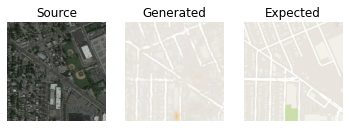

In [53]:
[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)